In [1]:
#libraries
import re
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import pysal.model.spreg as spreg
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pysal.lib
import geopandas as gpd
import pandas as pd
from libpysal.weights import DistanceBand
from scipy.spatial import distance_matrix
import pandas as pd
from scipy.stats import pearsonr
from esda.moran import Moran
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import spreg
from spreg import SURlagIV
from spreg import GM_Lag
import libpysal
from spreg import AKtest
from spreg import ML_Lag
from spreg import GM_Combo

**Loading Path**

In [2]:
# Dependent variable
dep_var_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\2.2 Saving the Dependent Variables"

# Independent variable
ind_var_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\1.2 Saving the Independent Variables"

# Steamengines and horsepower
power_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data"

In [3]:
# lets read the metadata
with pd.io.stata.StataReader(r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data\control.dta") as reader:
    meta_control = reader.variable_labels()
    
with pd.io.stata.StataReader(r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data\_FINAL_c_steamenginges_1904.dta") as reader:
    meta_steam = reader.variable_labels()

In [4]:
meta_control

{'id_inequality': 'County ID',
 'rb_id': 'District ID',
 'rb_name': 'District name',
 'province_id': 'Province ID',
 's_industry': 'Share industry employment',
 's_prot': 'Share Protestants',
 's_german': 'Share German-speaking',
 'longitud': 'Longitude',
 'latitud': 'Latitude',
 'slope_km': 'Terrain slope',
 'soil_suitability': 'Soil suitability',
 'mean_temp': 'Average temperature',
 'mean_preci': 'Average precipitation',
 'dist_100km': 'Distance to the nearest river',
 'log_distance_carbon_c': 'Least distance to carbon field (in log)'}

In [5]:
# Load Skill levels per Landkreis
skills_df = pd.read_csv(f"{dep_var_path}\Main_Dep.csv",
                        sep=",")

# Load control variables
control_df = pd.read_csv(f"{ind_var_path}\Independent Variables.csv",
                         sep=",")

# Load SteamEngine and Horsepower data
power_df = pd.read_stata(f"{power_path}\_FINAL_c_steamenginges_1904.dta")

In [6]:
# Merge the dataframes using an inner join on the "id_inequality" column
prep_df = pd.merge(control_df, skills_df, on="id_inequality", how="inner")
merged_df = pd.merge(prep_df, power_df, on="id_inequality", how="inner")

In [7]:
# Transform steamengines to steamengines per worker
merged_df["steamengines_number"] = (merged_df["steamengines_number"] / merged_df["d_Hauptberuf"])*1000
merged_df["horsepower"] = (merged_df["horsepower"] / merged_df["d_Hauptberuf"])*1000

merged_df["steamengines_number"] = np.log(merged_df["steamengines_number"])
merged_df["horsepower"] = np.log(merged_df["horsepower"])

In [8]:
# Drop Erblanden
#district_Erblanden = [31]
#merged_df = merged_df[~merged_df["rb_id"].isin(district_Erblanden)]

In [9]:
merged_df["per_unskilled"] = np.log(merged_df['per_unskilled'])
merged_df["per_low"] = np.log(merged_df['per_low'])
merged_df["per_medium"] = np.log(merged_df['per_medium'])
merged_df["per_high"] = np.log(merged_df['per_high'])

# Spatial Autocorrelation
First I check for spatial autocorrelation

In [10]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitud, merged_df.latitud))

In [11]:
# Compute the distance matrix
dist_matrix = distance_matrix(merged_df[["longitud", "latitud"]], merged_df[["longitud", "latitud"]])

# Compute the mean, median and 99th percentile distance
mean_distance = dist_matrix.mean()
median_distance = np.median(dist_matrix) 
percentile = np.percentile(dist_matrix, 99)

# Output
print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"99th percentile: {percentile}")

Mean Distance: 5.704669124084842
Median Distance: 4.927124335311768
99th percentile: 15.027893188430875


In [12]:
# Creating spatial weights matrix (Euclidean distance)
w = DistanceBand.from_dataframe(gdf, threshold=median_distance, binary=False)

# Transform the matrix so all rows add up to 1
w.transform = "r"

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [13]:
# Check variables for spatial autocorrelation
mi_carbon = Moran(gdf["log_distance_carbon_c"], w)
mi_steam = Moran((gdf["steamengines_number"]), w)
mi_hp = Moran((gdf["horsepower"]), w)
mi_unskilled = Moran(gdf["per_unskilled"], w)
mi_low = Moran(gdf["per_low"], w)
mi_medium = Moran(gdf["per_medium"], w)
mi_high = Moran(gdf["per_high"], w)

# Output Moran's I value and p-value
print(f"log_distance_carbon_c - Moran's I: {mi_carbon.I}, p-value: {mi_carbon.p_sim}")
print(f"steamengines_number - Moran's I: {mi_steam.I}, p-value: {mi_steam.p_sim}")
print(f"horsepower - Moran's I: {mi_hp.I}, p-value: {mi_hp.p_sim}")
print(f"Unskilled - Moran's I: {mi_unskilled.I}, p-value: {mi_unskilled.p_sim}")
print(f"Low - Moran's I: {mi_low.I}, p-value: {mi_low.p_sim}")
print(f"Medium - Moran's I: {mi_medium.I}, p-value: {mi_medium.p_sim}")
print(f"High - Moran's I: {mi_high.I}, p-value: {mi_high.p_sim}")

log_distance_carbon_c - Moran's I: 0.3936368232919114, p-value: 0.001
steamengines_number - Moran's I: 0.09130664899311283, p-value: 0.001
horsepower - Moran's I: 0.17660521325922168, p-value: 0.001
Unskilled - Moran's I: 0.09185844426409279, p-value: 0.001
Low - Moran's I: 0.22295728806946738, p-value: 0.001
Medium - Moran's I: 0.11441762544703019, p-value: 0.001
High - Moran's I: 0.0984206523270208, p-value: 0.001


# Make Dummies for FE

In [14]:
dummies = pd.get_dummies(merged_df["province_id"], drop_first=True) * 1
merged_df = pd.concat([merged_df, dummies], axis=1)

# Convert column names to strings
merged_df.columns = [str(col) for col in merged_df.columns]

In [15]:
# Dictionary
number_words = {
    "1": "one", "2": "two", "3": "three", "4": "four", "5": "five",
    "6": "six", "7": "seven", "8": "eight", "9": "nine", "10": "ten",
    "11": "eleven", "12": "twelve", "13": "thirteen", "14": "fourteen"
}

# Transform the column names
merged_df.columns = [number_words[col.split('.')[0]] if col.split('.')[0] in number_words else col for col in merged_df.columns]

merged_df

,id_inequality,rb_id,rb_name_x,province_id,s_industry,s_prot,s_german,longitud,latitud,slope_km,...,five,six,seven,eight,nine,ten,eleven,twelve,thirteen,fourteen
0,1.0,17.0,Koenigsberg,1.0,18.515817,93.379268,56.527919,21.261999,55.648117,0.039,...,0,0,0,0,0,0,0,0,0,0
1,2.0,17.0,Koenigsberg,1.0,20.088563,96.752059,99.449711,20.249264,54.843463,0.041,...,0,0,0,0,0,0,0,0,0,0
2,4.0,17.0,Koenigsberg,1.0,35.498406,91.659959,99.395196,20.503550,54.706534,0.041,...,0,0,0,0,0,0,0,0,0,0
3,5.0,17.0,Koenigsberg,1.0,15.060419,97.782661,99.669951,20.646094,54.737281,0.039,...,0,0,0,0,0,0,0,0,0,0
4,6.0,17.0,Koenigsberg,1.0,12.007056,98.668155,89.094425,21.267903,54.855057,0.038,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,698.0,1.0,Aachen,12.0,15.278715,1.613553,70.916132,6.167253,50.364714,0.143,...,0,0,0,0,0,0,0,1,0,0
571,699.0,31.0,Sigmaringen,14.0,19.492555,5.190840,99.167226,9.235305,48.006617,0.165,...,0,0,0,0,0,0,0,0,0,1
572,700.0,31.0,Sigmaringen,14.0,23.974037,2.518404,99.882758,9.198332,48.235600,0.186,...,0,0,0,0,0,0,0,0,0,1
573,701.0,31.0,Sigmaringen,14.0,30.325834,6.910838,99.726559,9.001089,48.317343,0.182,...,0,0,0,0,0,0,0,0,0,1


# 2SLS
Lets run a good'ol reliable IV first

## 2SLS function
I build a function that runs multiple 2SLS in a row, each time adding another variable from a list of control variables

In [16]:
def twoSLS(df, IV, first_stage_dependent, controls, second_stage_independent):
    """
    Performs a series of Two-Stage Least Squares (2SLS) regressions on a given DataFrame.
    In each iteration, an additional control variable from the provided list is included.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    controls (list of str): A list of control variable names. Each iteration includes an additional control variable.
    second_stage_independent (str): The name of the main independent variable for the second stage regression.

    Returns:
    tuple of DataFrames: The first DataFrame contains the results (coefficients, significance, 
                         Adj. R-squared, F-statistic) of each first stage regression. 
                         The second DataFrame contains the results 
                         of each second stage regression. Significance is denoted by stars: 
                         *** for p < 0.01, ** for p < 0.05, and * for p < 0.1.
                         The third DataFrame contains the residuals.
    """

    first_stage_results = []
    second_stage_results = []
    # For analysis of spatial autocorrelation
    residuals = []

    for i in range(len(controls) + 1):
        # Subset of control variables for this iteration
        subset_controls = controls[:i]

        # Build the formula, handling the case with no controls
        controls_formula_part = " + ".join(subset_controls)
        if controls_formula_part:
            controls_formula_part = " + " + controls_formula_part

        # To avoid SettingWithCopyWarning
        df_copy = df.copy()

        # First Stage Regression
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()

        # Add the predicted values as a new column in the copy
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression
        second_stage_formula = f"{second_stage_independent} ~ predicted{controls_formula_part}"
        second_stage_model = smf.ols(second_stage_formula, data=df_copy)
        second_stage_fit = second_stage_model.fit()

        def format_coef(coef, std_err, p_value):
            stars = ""
            if p_value < 0.01:
                stars = "***"
            elif p_value < 0.05:
                stars = "**"
            elif p_value < 0.1:
                stars = "*"
    
            # Check if coef or std_err is smaller than 0.000 and format accordingly
            coef_str = f"{coef:.10e}" if abs(coef) < 0.000 else f"{coef:.6f}"
            std_err_str = f"{std_err:.10e}" if abs(std_err) < 0.000 else f"{std_err:.6f}"

            return f"{coef_str}{stars} ({std_err_str})"


        # Extract coefficients and significance of first stage
        first_stage_summary = first_stage_fit.summary2().tables[1]
        first_stage_coefs = first_stage_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)

        # Extract coefficients and significance of second stage
        second_stage_summary = second_stage_fit.summary2().tables[1]
        second_stage_coefs = second_stage_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)

        # Adding R-squared and F-statistic
        first_stage_coefs.loc["Adj. R-squared"] = f"{first_stage_fit.rsquared_adj:.3f}"
        first_stage_coefs.loc["F-statistic"] = f"{first_stage_fit.fvalue:.3f}"
        second_stage_coefs.loc["Adj. R-squared"] = f"{second_stage_fit.rsquared_adj:.3f}"
        
        # Adding Standard Errors
        second_stage_se = second_stage_fit.bse["predicted"]
        second_stage_coefs.loc["std err"] = second_stage_se
        
        # Residuals
        res = second_stage_fit.resid
        
        # Append 
        first_stage_results.append(first_stage_coefs)
        second_stage_results.append(second_stage_coefs)
        residuals.append(res)

    # Convert the results to DataFrame
    first_stage_df = pd.DataFrame(first_stage_results).T
    second_stage_df = pd.DataFrame(second_stage_results).T
    
    # Df of residuals
    residuals_df = pd.DataFrame(residuals).T

    return first_stage_df, second_stage_df, residuals_df

## Use the Function

In [17]:
# DataFrame that contains all the variables for the regression analysis
dep_var = merged_df[["log_distance_carbon_c", 
                     "s_industry",
                     "s_prot", 
                     "s_german", 
                     "longitud", 
                     "latitud", 
                     "soil_suitability", 
                     "mean_temp", 
                     "mean_preci", 
                     "dist_100km",
                     "uni_dummy", 
                     "min_distance_uni", 
                     "prov_cap_dummy", 
                     "BER_dummy", 
                     "density",
                     "steamengines_number",
                     "per_low",
                     "per_medium",
                     "per_unskilled",
                     "per_high",
                     "d_Hauptberuf",
                     "horsepower",
                     "two", 
                     "three", 
                     "four", 
                     "five", 
                     "six", 
                     "seven", 
                     "eight", 
                     "nine", 
                     "ten", 
                     "eleven", 
                     "twelve", 
                     "thirteen", 
                     "fourteen"]]

In [18]:
# Make two lists of exogenous variables
# Exclude latitude and longitude once
control_list = ["longitud",
                "latitud",
                "soil_suitability", 
                "mean_temp", 
                "mean_preci", 
                "dist_100km",
                "s_prot", 
                "s_german",
                "density",
                "min_distance_uni", 
                "prov_cap_dummy", 
                "two", 
                "three", 
                "four", 
                "five", 
                "six", 
                "seven", 
                "eight", 
                "nine", 
                "ten", 
                "eleven", 
                "twelve", 
                "thirteen", 
                "fourteen"]

control_list_2 = ["soil_suitability", 
                "mean_temp", 
                "mean_preci", 
                "dist_100km",
                "s_prot", 
                "s_german",
                "density",
                "min_distance_uni", 
                "prov_cap_dummy", 
                "two", 
                "three", 
                "four", 
                "five", 
                "six", 
                "seven", 
                "eight", 
                "nine", 
                "ten", 
                "eleven", 
                "twelve", 
                "thirteen", 
                "fourteen"]

In [19]:
first_unskilled, second_unskilled, res_unskilled = twoSLS(dep_var,
                                                          "log_distance_carbon_c",
                                                          "steamengines_number",
                                                          control_list,
                                                          "per_unskilled")

first_low, second_low, res_low = twoSLS(dep_var,
                                        "log_distance_carbon_c",
                                        "steamengines_number",
                                        control_list,
                                        "per_low")

first_medium, second_medium, res_medium = twoSLS(dep_var,
                                                 "log_distance_carbon_c",
                                                 "steamengines_number",
                                                 control_list,
                                                 "per_medium")

first_high, second_high, res_high = twoSLS(dep_var,
                                           "log_distance_carbon_c",
                                           "steamengines_number",
                                           control_list,
                                           "per_high")

In [20]:
first_unskilled[[1,2,3,24]]

,1,2,3,24
Intercept,2.646475*** (0.074909),-5.260952*** (1.133434),-5.614617*** (1.109793),-6.131837** (2.391058)
log_distance_carbon_c,-0.095315*** (0.016460),-0.187567*** (0.020595),-0.191147*** (0.020140),-0.169092*** (0.022666)
Adj. R-squared,0.053,0.126,0.166,0.351
F-statistic,17.174,28.697,29.475,13.914
longitud,0.008266 (0.005484),0.000577 (0.005382),-0.004367 (0.005343),0.097567*** (0.023642)
latitud,NaN,0.160213*** (0.022918),0.173760*** (0.022546),0.080851* (0.044009)
soil_suitability,NaN,NaN,-0.116933*** (0.022189),-0.116329*** (0.021474)
mean_temp,NaN,NaN,NaN,0.331239*** (0.043187)
mean_preci,NaN,NaN,NaN,0.009471*** (0.003215)
dist_100km,NaN,NaN,NaN,-0.096685 (0.113560)


In [21]:
# First Stage (same for every regression)
second_unskilled[[1,2,3,24]]

,1,2,3,24
Intercept,0.034012 (0.220705),-1.719653*** (0.482898),-1.795856*** (0.482046),-3.957010*** (1.246220)
predicted,-0.396600*** (0.088992),-0.234471*** (0.058916),-0.228728*** (0.057872),-0.203168*** (0.071750)
Adj. R-squared,0.094,0.093,0.092,0.329
std err,0.088992,0.058916,0.057872,0.07175
longitud,0.014858*** (0.002618),0.012230*** (0.002882),0.010739*** (0.002986),-0.004868 (0.014345)
latitud,NaN,0.026838*** (0.009569),0.029994*** (0.009750),0.098498*** (0.022234)
soil_suitability,NaN,NaN,-0.035186** (0.013739),-0.028046* (0.014282)
mean_temp,NaN,NaN,NaN,-0.117278*** (0.034721)
mean_preci,NaN,NaN,NaN,-0.004664** (0.002018)
dist_100km,NaN,NaN,NaN,0.000265 (0.060272)


In [22]:
second_low[[1,2,3,24]]

,1,2,3,24
Intercept,-3.317549*** (0.236965),2.508948*** (0.515988),2.655968*** (0.513181),4.371783*** (1.382825)
predicted,0.889596*** (0.095549),0.350929*** (0.062953),0.339847*** (0.061610),0.307869*** (0.079615)
Adj. R-squared,0.262,0.269,0.273,0.416
std err,0.095549,0.062953,0.06161,0.079615
longitud,-0.026247*** (0.002811),-0.017515*** (0.003080),-0.014639*** (0.003179),-0.029039* (0.015918)
latitud,NaN,-0.089167*** (0.010225),-0.095257*** (0.010380),-0.126202*** (0.024672)
soil_suitability,NaN,NaN,0.067885*** (0.014626),0.051243*** (0.015847)
mean_temp,NaN,NaN,NaN,0.041229 (0.038526)
mean_preci,NaN,NaN,NaN,0.004316* (0.002239)
dist_100km,NaN,NaN,NaN,-0.037767 (0.066879)


In [23]:
second_medium[[1,2,3,24]]

,1,2,3,24
Intercept,-1.265158*** (0.158351),-2.657236*** (0.339742),-2.669373*** (0.337523),-2.029769** (0.890430)
predicted,0.000789 (0.063850),0.129488*** (0.041450),0.130403*** (0.040521),0.086063* (0.051266)
Adj. R-squared,0.043,0.080,0.088,0.298
std err,0.06385,0.04145,0.040521,0.051266
longitud,-0.009818*** (0.001878),-0.011904*** (0.002028),-0.012141*** (0.002091),0.014356 (0.010250)
latitud,NaN,0.021304*** (0.006732),0.021807*** (0.006827),-0.013222 (0.015887)
soil_suitability,NaN,NaN,-0.005604 (0.009620),-0.008490 (0.010204)
mean_temp,NaN,NaN,NaN,0.080175*** (0.024808)
mean_preci,NaN,NaN,NaN,0.002254 (0.001442)
dist_100km,NaN,NaN,NaN,0.017711 (0.043065)


In [24]:
second_high[[1,2,3,24]]

,1,2,3,24
Intercept,-5.559071*** (0.395936),-5.689167*** (0.859571),-5.583830*** (0.858414),-0.399058 (2.269460)
predicted,0.402096** (0.159648),0.414124*** (0.104872),0.406184*** (0.103057),0.529271*** (0.130662)
Adj. R-squared,0.052,0.066,0.064,0.277
std err,0.159648,0.104872,0.103057,0.130662
longitud,-0.022218*** (0.004696),-0.022413*** (0.005130),-0.020352*** (0.005318),-0.019925 (0.026124)
latitud,NaN,0.001991 (0.017033),-0.002372 (0.017362),-0.104514** (0.040490)
soil_suitability,NaN,NaN,0.048638** (0.024466),0.070259*** (0.026008)
mean_temp,NaN,NaN,NaN,0.072054 (0.063229)
mean_preci,NaN,NaN,NaN,0.001352 (0.003674)
dist_100km,NaN,NaN,NaN,-0.072967 (0.109760)


# Check error terms for spatial autocorrelation
Use the residuals

## Unskilled

In [25]:
test_statistics = []
p_values = []

for column in res_unskilled.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.003
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.01
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.019
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.013
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.006
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.011
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.063
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.033
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.025
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.086
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.032
Variable 13: Test Statistic = 0.007997651924012745, P-value = 0.056
Variable 14: Test Statistic = 0.007997803386160506, P-value = 0.057
Variable 15: Test Statistic = 0.008051315249689257, P-value =

## Low

In [26]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.009
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.014
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.017
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.013
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.004
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.014
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.059
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.028
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.023
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.091
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.023
Variable 13: Test Statistic = 0.007997651924012745, P-value = 0.059
Variable 14: Test Statistic = 0.007997803386160506, P-value = 0.062
Variable 15: Test Statistic = 0.008051315249689257, P-value 

## Medium

In [27]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.009
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.013
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.014
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.011
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.009
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.015
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.043
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.032
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.02
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.078
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.038
Variable 13: Test Statistic = 0.007997651924012745, P-value = 0.05
Variable 14: Test Statistic = 0.007997803386160506, P-value = 0.045
Variable 15: Test Statistic = 0.008051315249689257, P-value = 

## High

In [28]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.009
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.009
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.009
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.012
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.007
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.02
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.06
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.026
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.027
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.074
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.033
Variable 13: Test Statistic = 0.007997651924012745, P-value = 0.054
Variable 14: Test Statistic = 0.007997803386160506, P-value = 0.055
Variable 15: Test Statistic = 0.008051315249689257, P-value = 

# Control for spatial autocorrelation

## IV with lag
In the second stage, lag controls on the dependent variable (i.e. skill share)

### Function

In [29]:
def IV_w_lag(df, IV, first_stage_dependent, dependent_var, controls, w):
    """
    Performs a series of IV regressions with spatial lag in the second-stage,
    incorporating a first-stage regression similar to twoSLS.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names for both stages.
    w (libpysal.weights): weight matrix to control for spatial autocorrelation.

    Returns:
    Tuple of DataFrames
    First DataFrame containing the results of each second stage regression.
    Second DataFrame containing the residuals.
    Third DataFrame containing the pseudo-Rsquares.
    Fourth DataFrame containing the p-values from the AK test.
    """

    results = []
    res = []
    # Pseudo R-Squared
    pseudo_R = []
    # AKtest
    ak_pvalues = []

    for i in range(len(controls) + 1):
        subset_controls = controls[:i]

        # First Stage Regression
        df_copy = df.copy()
        controls_formula_part = " + ".join(subset_controls)
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{(' + ' if controls_formula_part else '')}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression (Spatial Lag)
        X = df_copy[["predicted"] + subset_controls]
        y = df_copy[dependent_var]
        slm = spreg.ML_Lag(y.values, X.values, w, slx_lags = 0, name_y=dependent_var, name_x=["predicted"] + subset_controls)

        # Formatting results
        p_value = slm.output["prob"]
        coefs = slm.output["coefficients"]
        names = slm.output["var_names"]
        std = slm.output["std_err"]
        r = slm.pr2
        residuals = slm.e_pred
        
        # AKtest
        ak = AKtest(slm, w)
        ak_pvalues.append(ak.p)
        
        results.append(names)
        results.append(coefs)
        results.append(p_value)
        results.append(std)
        res.append(list(residuals))
        pseudo_R.append(r)

    # Convert the results to DataFrame
    results_df = pd.DataFrame(results).T
    residuals_df = pd.DataFrame(res).T
    residuals_df = residuals_df.astype(float)
    pseudoR_df = pd.DataFrame(pseudo_R)
    ak_pvalues_df = pd.DataFrame(ak_pvalues)

    return results_df, residuals_df, pseudoR_df, ak_pvalues_df

### Run the Function

In [30]:
lag_unskilled_second, res_lag_unskilled, R_un, ak_un = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                          "per_unskilled", control_list, w)
lag_low_second, res_lag_low, R_low, ak_low = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                              "per_low", control_list, w)
lag_medium_second, res_lag_medium, R_medium, ak_medium = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                       "per_medium", control_list, w)
lag_high_second, res_lag_high, R_high, ak_high = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                 "per_high", control_list, w)

In [31]:
pd.set_option('display.max_columns', 40)

#### Unskilled

In [32]:
lag_unskilled_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,0.64423,0.002863,0.216035,CONSTANT,0.360176,0.143539,0.246234,CONSTANT,-1.042047,0.051596,0.535346,CONSTANT,-1.111038,0.038816,0.537738,CONSTANT,-0.7232,0.219859,0.589452,...,CONSTANT,-3.174663,0.001644,1.008471,CONSTANT,-3.035457,0.00411,1.057805,CONSTANT,-4.370817,0.002063,1.418617,CONSTANT,-4.417016,0.001898,1.422214,CONSTANT,-0.051486,1.0,212863.20139
1,predicted,-0.369995,0.00014,0.097172,predicted,-0.324067,0.000353,0.090704,predicted,-0.195229,0.000916,0.058889,predicted,-0.191638,0.000921,0.057833,predicted,-0.219134,0.000044,0.053641,...,predicted,-0.225728,0.001797,0.072306,predicted,-0.223916,0.001804,0.071751,predicted,-0.201901,0.004465,0.071009,predicted,-0.201316,0.004579,0.071004,predicted,-0.14987,0.088478,0.087979
2,W_per_unskilled,0.657876,0.000001,0.133684,longitud,0.006449,0.080489,0.00369,longitud,0.004417,0.247159,0.003817,longitud,0.003442,0.373325,0.003867,longitud,-0.000671,0.875581,0.004287,...,longitud,-0.010185,0.449741,0.013475,longitud,-0.01115,0.408495,0.01349,longitud,-0.005964,0.675138,0.014231,longitud,-0.005191,0.717196,0.014332,longitud,-0.014631,0.405938,0.017606
3,NaN,NaN,NaN,NaN,W_per_unskilled,0.531724,0.003552,0.182382,latitud,0.02142,0.026417,0.009649,latitud,0.023875,0.015419,0.009856,latitud,0.026007,0.008649,0.009905,...,latitud,0.082059,0.000004,0.01787,latitud,0.080299,0.000014,0.018476,latitud,0.097527,0.000008,0.021797,latitud,0.09825,0.000007,0.021839,latitud,0.067673,0.013124,0.027283
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.527582,0.004126,0.183932,soil_suitability,-0.026283,0.05437,0.013661,soil_suitability,-0.029847,0.025466,0.013359,...,soil_suitability,-0.030124,0.031488,0.014006,soil_suitability,-0.030018,0.031814,0.013983,soil_suitability,-0.026587,0.0566,0.013946,soil_suitability,-0.027607,0.050771,0.014132,soil_suitability,-0.014342,0.412804,0.017513
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.518185,0.005339,0.186005,mean_temp,-0.060822,0.005149,0.021741,...,mean_temp,-0.10681,0.001932,0.034449,mean_temp,-0.109059,0.001498,0.034348,mean_temp,-0.116168,0.000655,0.03409,mean_temp,-0.117253,0.000588,0.034113,mean_temp,-0.102719,0.015834,0.042574
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.315707,0.149998,0.219311,...,mean_preci,-0.004222,0.033328,0.001984,mean_preci,-0.004375,0.028206,0.001994,mean_preci,-0.0047,0.017831,0.001984,mean_preci,-0.004647,0.019275,0.001986,mean_preci,-0.003875,0.117281,0.002474
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.008037,0.891282,0.058804,dist_100km,0.006854,0.907313,0.058873,dist_100km,0.001491,0.979808,0.058923,dist_100km,-0.000115,0.99844,0.058965,dist_100km,0.052807,0.475269,0.073966
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000207,0.681299,0.000503,s_prot,-0.000144,0.790124,0.000541,s_prot,-0.00025,0.643475,0.00054,s_prot,-0.00027,0.617574,0.000541,s_prot,-0.00021,0.756514,0.000679
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,-0.002261,0.001089,0.000692,s_german,-0.002293,0.001009,0.000698,s_german,-0.002309,0.000922,0.000697,s_german,-0.002307,0.00093,0.000697,s_german,-0.002565,0.003314,0.000873


In [33]:
R_un

,0
0,0.110896
1,0.109663
2,0.110609
3,0.110617
4,0.169970
5,0.186115
6,0.191050
7,0.204191
8,0.220602
9,0.224656


In [34]:
ak_un

,0
0,0.551089
1,0.901857
2,0.778387
3,0.747073
4,0.430812
5,0.109389
6,0.164558
7,0.404319
8,0.280843
9,0.264617


#### Low

In [35]:
lag_low_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.951482,0.0,0.321255,CONSTANT,-1.690573,0.0,0.278282,CONSTANT,2.150689,0.00002,0.50376,CONSTANT,2.264429,0.000007,0.503662,CONSTANT,2.208377,0.000049,0.543839,...,CONSTANT,2.273374,0.032958,1.066012,CONSTANT,2.533598,0.024992,1.130297,CONSTANT,4.829474,0.001761,1.544005,CONSTANT,4.962141,0.001349,1.548131,CONSTANT,3.450305,0.999989,254072.135114
1,predicted,0.686658,0.0,0.106514,predicted,0.614931,0.0,0.09527,predicted,0.263713,0.000018,0.061444,predicted,0.258286,0.000019,0.060318,predicted,0.264724,0.000003,0.056789,...,predicted,0.311877,0.000124,0.081261,predicted,0.316679,0.000086,0.080638,predicted,0.280989,0.000409,0.079511,predicted,0.281244,0.000402,0.079473,predicted,0.262865,0.005022,0.093693
2,W_per_low,0.803607,0.0,0.072272,longitud,-0.00355,0.315638,0.003538,longitud,0.001569,0.66482,0.003621,longitud,0.003075,0.408429,0.00372,longitud,0.002863,0.500867,0.004253,...,longitud,-0.009673,0.525822,0.015248,longitud,-0.011809,0.440424,0.015307,longitud,-0.020855,0.197028,0.016166,longitud,-0.022698,0.163371,0.016285,longitud,-0.008889,0.634965,0.018724
3,NaN,NaN,NaN,NaN,W_per_low,0.833517,0.0,0.085303,latitud,-0.059569,0.0,0.010576,latitud,-0.064687,0.0,0.010939,latitud,-0.066478,0.0,0.011275,...,latitud,-0.084131,0.000038,0.020412,latitud,-0.087806,0.000029,0.021013,latitud,-0.11713,0.000002,0.024741,latitud,-0.118762,0.000002,0.024772,latitud,-0.133296,0.000005,0.029114
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.807281,0.0,0.095853,soil_suitability,0.047962,0.000823,0.014338,soil_suitability,0.04916,0.000553,0.014234,...,soil_suitability,0.047773,0.002416,0.015747,soil_suitability,0.048276,0.002113,0.015705,soil_suitability,0.04288,0.006008,0.015608,soil_suitability,0.045378,0.004118,0.015817,soil_suitability,0.032884,0.077925,0.018654
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.785045,0.0,0.103063,mean_temp,0.007368,0.7498,0.023104,...,mean_temp,0.031435,0.410307,0.03818,mean_temp,0.027163,0.47462,0.037991,mean_temp,0.039255,0.297459,0.037677,mean_temp,0.041563,0.270099,0.037687,mean_temp,0.053508,0.237991,0.045345
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.738239,0.0,0.115671,...,mean_preci,0.00393,0.075181,0.002209,mean_preci,0.003651,0.099323,0.002215,mean_preci,0.004215,0.055716,0.002203,mean_preci,0.004118,0.061612,0.002203,mean_preci,0.003929,0.135881,0.002635
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.046309,0.478517,0.065345,dist_100km,-0.048582,0.457198,0.065346,dist_100km,-0.039856,0.541639,0.065301,dist_100km,-0.036889,0.572166,0.065306,dist_100km,0.02939,0.708791,0.078692
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000833,0.141824,0.000567,s_prot,-0.000722,0.23547,0.000608,s_prot,-0.000543,0.369995,0.000606,s_prot,-0.000502,0.407769,0.000606,s_prot,-0.000005,0.994644,0.000722
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.001965,0.010818,0.000771,s_german,0.001898,0.014406,0.000776,s_german,0.001915,0.013332,0.000774,s_german,0.001902,0.013915,0.000773,s_german,0.00225,0.015517,0.00093


In [36]:
R_low

,0
0,0.307651
1,0.308910
2,0.310089
3,0.311713
4,0.328753
5,0.351801
6,0.357437
7,0.359577
8,0.377749
9,0.377835


In [37]:
ak_low

,0
0,1.785401e-01
1,2.577939e-01
2,1.866396e-01
3,2.622229e-01
4,1.119218e-01
5,1.348034e-01
6,2.146108e-01
7,3.041157e-01
8,4.999253e-01
9,4.992933e-01


#### Medium

In [38]:
lag_medium_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-0.222009,0.204594,0.175007,CONSTANT,-0.204934,0.241536,0.174984,CONSTANT,-1.085342,0.003205,0.368237,CONSTANT,-1.097235,0.002759,0.366557,CONSTANT,-1.519975,0.000065,0.380651,...,CONSTANT,-0.289804,0.691977,0.731508,CONSTANT,-0.876276,0.261,0.779584,CONSTANT,-1.397426,0.186725,1.058391,CONSTANT,-1.511367,0.156097,1.065602,CONSTANT,3.522759,0.999986,197276.982536
1,predicted,0.029762,0.632567,0.062249,predicted,0.022158,0.715764,0.060852,predicted,0.096068,0.016453,0.04005,predicted,0.09753,0.012532,0.039062,predicted,0.105937,0.003483,0.036261,...,predicted,0.078827,0.122325,0.051018,predicted,0.072714,0.150081,0.050522,predicted,0.080327,0.10818,0.050003,predicted,0.08032,0.108109,0.049989,predicted,0.114423,0.146048,0.078715
2,W_per_medium,0.895493,0.0,0.059769,longitud,-0.00059,0.74389,0.001806,longitud,-0.002388,0.258746,0.002115,longitud,-0.002762,0.208425,0.002196,longitud,0.001431,0.569028,0.002513,...,longitud,0.010852,0.254998,0.009533,longitud,0.013917,0.1438,0.00952,longitud,0.015586,0.120211,0.010031,longitud,0.016403,0.104438,0.010102,longitud,0.01604,0.309053,0.015768
3,NaN,NaN,NaN,NaN,W_per_medium,0.889341,0.0,0.062787,latitud,0.012456,0.057625,0.006561,latitud,0.013324,0.045515,0.006662,latitud,0.01358,0.035688,0.006465,...,latitud,-0.030295,0.016354,0.012618,latitud,-0.023768,0.068722,0.013057,latitud,-0.017568,0.257807,0.015525,latitud,-0.016485,0.289515,0.015564,latitud,-0.095216,0.000101,0.024483
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.833584,0.0,0.086241,soil_suitability,-0.010325,0.264828,0.00926,soil_suitability,-0.010218,0.25812,0.009036,...,soil_suitability,-0.009543,0.333399,0.009865,soil_suitability,-0.009724,0.322465,0.009828,soil_suitability,-0.008518,0.384821,0.009802,soil_suitability,-0.009702,0.329243,0.009945,soil_suitability,-0.006118,0.69619,0.015669
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.839136,0.0,0.083289,mean_temp,0.037561,0.011385,0.014842,...,mean_temp,0.076298,0.001829,0.02448,mean_temp,0.084645,0.000505,0.024336,mean_temp,0.082161,0.000674,0.024165,mean_temp,0.080995,0.000809,0.024181,mean_temp,0.119233,0.001747,0.038091
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.829539,0.0,0.088627,...,mean_preci,0.001735,0.217796,0.001408,mean_preci,0.002304,0.102122,0.00141,mean_preci,0.002189,0.118875,0.001404,mean_preci,0.002235,0.111584,0.001405,mean_preci,0.003061,0.166731,0.002214
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.023232,0.579929,0.041974,dist_100km,0.026958,0.520257,0.041929,dist_100km,0.024819,0.554427,0.041985,dist_100km,0.023037,0.583472,0.042014,dist_100km,0.21169,0.001373,0.066147
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,0.00069,0.058092,0.000364,s_prot,0.000476,0.220615,0.000389,s_prot,0.000448,0.247745,0.000387,s_prot,0.000436,0.261464,0.000388,s_prot,0.000782,0.199589,0.00061
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.002138,0.000015,0.000494,s_german,0.002246,0.000006,0.000497,s_german,0.002238,0.000006,0.000496,s_german,0.002242,0.000006,0.000496,s_german,0.002422,0.001937,0.000781


In [39]:
R_medium

,0
0,0.138487
1,0.137180
2,0.145544
3,0.155965
4,0.194128
5,0.195657
6,0.196599
7,0.215303
8,0.231681
9,0.234956


In [40]:
ak_medium

,0
0,7.558529e-01
1,7.457472e-01
2,6.827675e-01
3,8.987409e-01
4,9.595884e-01
5,8.424530e-01
6,8.803965e-01
7,6.177782e-01
8,6.998335e-01
9,6.358397e-01


#### High

In [41]:
lag_high_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.452989,0.008298,0.550437,CONSTANT,-1.339159,0.008464,0.50861,CONSTANT,-1.400264,0.124751,0.912145,CONSTANT,-1.327787,0.143681,0.908063,CONSTANT,-2.461574,0.010035,0.95609,...,CONSTANT,-0.124986,0.947806,1.909302,CONSTANT,-1.867044,0.355423,2.020344,CONSTANT,2.081661,0.432841,2.654028,CONSTANT,2.558079,0.334469,2.650445,CONSTANT,2.118028,0.999998,1050600.879153
1,predicted,0.343844,0.030964,0.159368,predicted,0.321052,0.036636,0.153628,predicted,0.320293,0.001562,0.101262,predicted,0.315632,0.001493,0.099378,predicted,0.338298,0.000232,0.09189,...,predicted,0.551399,0.000024,0.130414,predicted,0.535152,0.000034,0.129142,predicted,0.473729,0.000202,0.127483,predicted,0.471619,0.00021,0.127218,predicted,0.450211,0.304356,0.438317
2,W_per_high,0.873137,0.0,0.067774,longitud,-0.001344,0.770871,0.004615,longitud,-0.001737,0.739255,0.00522,longitud,-0.00054,0.920024,0.005381,longitud,0.00968,0.118243,0.006196,...,longitud,-0.001699,0.943901,0.02415,longitud,0.008389,0.728257,0.024146,longitud,-0.006616,0.795087,0.025475,longitud,-0.010485,0.681902,0.025582,longitud,-0.004,0.963616,0.087692
3,NaN,NaN,NaN,NaN,W_per_high,0.881884,0.0,0.066174,latitud,-0.000404,0.980373,0.016414,latitud,-0.002793,0.867258,0.016712,latitud,-0.002382,0.883679,0.01628,...,latitud,-0.066811,0.037509,0.032118,latitud,-0.047362,0.154027,0.033226,latitud,-0.096709,0.01378,0.039266,latitud,-0.100523,0.010489,0.039277,latitud,-0.114554,0.39904,0.135835
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.8636,0.0,0.074102,soil_suitability,0.026544,0.259736,0.023553,soil_suitability,0.027297,0.23367,0.02292,...,soil_suitability,0.059737,0.018001,0.025252,soil_suitability,0.059802,0.017531,0.025176,soil_suitability,0.050287,0.044677,0.025047,soil_suitability,0.055248,0.029129,0.025323,soil_suitability,0.046121,0.59706,0.087246
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.866618,0.0,0.072761,mean_temp,0.094114,0.012321,0.037603,...,mean_temp,0.030542,0.624207,0.062344,mean_temp,0.055579,0.369709,0.061959,mean_temp,0.076223,0.214524,0.06141,mean_temp,0.082181,0.180354,0.061344,mean_temp,0.099109,0.640313,0.212107
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.842267,0.0,0.083243,...,mean_preci,-0.00094,0.793137,0.003585,mean_preci,0.000786,0.826612,0.003589,mean_preci,0.001749,0.623972,0.003567,mean_preci,0.00155,0.663592,0.003564,mean_preci,0.001909,0.876902,0.012326
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.081501,0.445631,0.106856,dist_100km,-0.069906,0.512502,0.106736,dist_100km,-0.054347,0.610296,0.106636,dist_100km,-0.045731,0.667676,0.106514,dist_100km,0.019014,0.958817,0.368204
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.001255,0.170131,0.000915,s_prot,-0.001971,0.044297,0.00098,s_prot,-0.001673,0.086855,0.000977,s_prot,-0.00158,0.105596,0.000976,s_prot,-0.001434,0.670954,0.003376
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.003463,0.00587,0.001257,s_german,0.003793,0.002683,0.001264,s_german,0.003834,0.002353,0.00126,s_german,0.003826,0.002354,0.001258,s_german,0.004172,0.337567,0.004351


In [42]:
R_high

,0
0,0.129250
1,0.130829
2,0.136096
3,0.136813
4,0.181735
5,0.182410
6,0.186411
7,0.189725
8,0.205091
9,0.208388


In [43]:
ak_high

,0
0,0.051214
1,0.056295
2,0.131370
3,0.108758
4,0.044357
5,0.031069
6,0.058137
7,0.103601
8,0.034130
9,0.029145


### Check if there is still spatial autocorrelation

#### Unskilled

In [44]:
for col in res_lag_unskilled.columns:
    res_lag_unskilled[col] = res_lag_unskilled[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_unskilled.columns:
    mi_res = Moran(res_lag_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.023525944368332514, P-value = 0.001
Variable 2: Test Statistic = 0.01570086061962296, P-value = 0.011
Variable 3: Test Statistic = 0.01352041062046587, P-value = 0.009
Variable 4: Test Statistic = 0.012788649490262594, P-value = 0.018
Variable 5: Test Statistic = 0.01594681249011586, P-value = 0.005
Variable 6: Test Statistic = 0.01726520242270739, P-value = 0.004
Variable 7: Test Statistic = 0.014463427030790564, P-value = 0.015
Variable 8: Test Statistic = 0.007698549409531949, P-value = 0.054
Variable 9: Test Statistic = 0.009954817946376742, P-value = 0.027
Variable 10: Test Statistic = 0.010363870464527776, P-value = 0.026
Variable 11: Test Statistic = 0.006186152028412164, P-value = 0.081
Variable 12: Test Statistic = 0.009839267691469847, P-value = 0.029
Variable 13: Test Statistic = 0.007984005181963892, P-value = 0.055
Variable 14: Test Statistic = 0.007987891951411927, P-value = 0.054
Variable 15: Test Statistic = 0.008065901277334952, P-value =

#### Low

In [45]:
for col in res_lag_low.columns:
    res_lag_low[col] = res_lag_low[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_low.columns:
    mi_res = Moran(res_lag_low[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.042761493000927325, P-value = 0.001
Variable 2: Test Statistic = 0.041250456969714695, P-value = 0.001
Variable 3: Test Statistic = 0.04565179018514577, P-value = 0.001
Variable 4: Test Statistic = 0.044613616454050924, P-value = 0.001
Variable 5: Test Statistic = 0.05565076675141374, P-value = 0.001
Variable 6: Test Statistic = 0.02013212382147748, P-value = 0.001
Variable 7: Test Statistic = 0.016925483560800456, P-value = 0.005
Variable 8: Test Statistic = 0.015990589303692918, P-value = 0.007
Variable 9: Test Statistic = 0.012608893041976658, P-value = 0.011
Variable 10: Test Statistic = 0.012828375520838091, P-value = 0.009
Variable 11: Test Statistic = 0.012777482087359715, P-value = 0.012
Variable 12: Test Statistic = 0.015534613693878707, P-value = 0.011
Variable 13: Test Statistic = 0.014419128166778697, P-value = 0.006
Variable 14: Test Statistic = 0.012789229052670801, P-value = 0.009
Variable 15: Test Statistic = 0.01278311793999517, P-value =

#### Medium

In [46]:
for col in res_lag_medium.columns:
    res_lag_medium[col] = res_lag_medium[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_medium.columns:
    mi_res = Moran(res_lag_medium[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.09784655347025936, P-value = 0.001
Variable 2: Test Statistic = 0.08355863775405259, P-value = 0.001
Variable 3: Test Statistic = 0.05129761817905917, P-value = 0.001
Variable 4: Test Statistic = 0.06051469226184662, P-value = 0.001
Variable 5: Test Statistic = 0.05678376974900078, P-value = 0.001
Variable 6: Test Statistic = 0.06636821322021132, P-value = 0.001
Variable 7: Test Statistic = 0.06556133823482321, P-value = 0.001
Variable 8: Test Statistic = 0.029400753865249315, P-value = 0.001
Variable 9: Test Statistic = 0.04111979895466488, P-value = 0.001
Variable 10: Test Statistic = 0.03586226962859265, P-value = 0.001
Variable 11: Test Statistic = 0.030648511685155092, P-value = 0.001
Variable 12: Test Statistic = 0.03128883588113737, P-value = 0.001
Variable 13: Test Statistic = 0.030962544233555156, P-value = 0.001
Variable 14: Test Statistic = 0.028917870999567896, P-value = 0.001
Variable 15: Test Statistic = 0.029059549480501115, P-value = 0.001

#### High

In [47]:
for col in res_lag_high.columns:
    res_lag_high[col] = res_lag_high[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_high.columns:
    mi_res = Moran(res_lag_high[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.052425936447987445, P-value = 0.001
Variable 2: Test Statistic = 0.058571235465201994, P-value = 0.001
Variable 3: Test Statistic = 0.0443148513614843, P-value = 0.001
Variable 4: Test Statistic = 0.04611881201005728, P-value = 0.001
Variable 5: Test Statistic = 0.053247981413093996, P-value = 0.001
Variable 6: Test Statistic = 0.05591976299591131, P-value = 0.001
Variable 7: Test Statistic = 0.05047584626087852, P-value = 0.001
Variable 8: Test Statistic = 0.0398354574857092, P-value = 0.001
Variable 9: Test Statistic = 0.04526442560842671, P-value = 0.001
Variable 10: Test Statistic = 0.043965503917444006, P-value = 0.001
Variable 11: Test Statistic = 0.04076431247582079, P-value = 0.001
Variable 12: Test Statistic = 0.03956634547087259, P-value = 0.001
Variable 13: Test Statistic = 0.03864855305901312, P-value = 0.001
Variable 14: Test Statistic = 0.03935095207325544, P-value = 0.001
Variable 15: Test Statistic = 0.04013882702592592, P-value = 0.001
Va

## IV with Error

### Function

ML_Error has no pseudo-Rsquared

In [48]:
def IV_w_error(df, IV, first_stage_dependent, dependent_var, controls, w):
    """
    Performs a series of IV regressions with spatial error in the second stage,
    incorporating a first-stage regression similar to twoSLS.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names for both stages.
    w (libpysal.weights): weight matrix to control for spatial autocorrelation.

    Returns:
    Tuple of DataFrames
    First DataFrame containing the results of each second stage regression.
    Second DataFrame containing the residuals.
    Third DataFrame containing the pseudo-Rsquares.
    Fourth DataFrame containing the p-values from the AK test.
    """

    results = []
    res = []
    # Pseudo R-Squared
    pseudo_R = []
    # AKtest
    ak_pvalues = []

    for i in range(len(controls) + 1):
        subset_controls = controls[:i]

        # First Stage Regression
        df_copy = df.copy()
        controls_formula_part = " + ".join(subset_controls)
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{(' + ' if controls_formula_part else '')}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression (Spatial Error)
        X = df_copy[["predicted"] + subset_controls]
        y = df_copy[dependent_var]
        slm = spreg.ML_Error(y.values, X.values, w,
                             name_y=dependent_var, name_x=["predicted"] + subset_controls)

        # Formatting results
        p_value = slm.output["prob"]
        coefs = slm.output["coefficients"]
        names = slm.output["var_names"]
        std = slm.output["std_err"]
        r = slm.pr2
        residuals = slm.u
        
        # AKtest
        ak = AKtest(slm, w)
        ak_pvalues.append(ak.p)

        results.append(names)
        results.append(coefs)
        results.append(p_value)
        results.append(std)
        res.append(list(residuals))
        pseudo_R.append(r)

    # Convert the results to DataFrame
    results_df = pd.DataFrame(results).T
    residuals_df = pd.DataFrame(res).T
    residuals_df = residuals_df.astype(float)
    pseudoR_df = pd.DataFrame(pseudo_R)
    ak_pvalues_df = pd.DataFrame(ak_pvalues)

    return results_df, residuals_df, pseudoR_df, ak_pvalues_df

### Run the Function

The error is no problem, it just tells me that the optimizing algorithm defaults to a different stopping point

In [49]:
error_unskilled_second, e_res_un, e_r2_un, e_ak_un = IV_w_error(dep_var, "log_distance_carbon_c",
                                                             "steamengines_number", "per_unskilled",
                                                             control_list, w)
error_low_second, e_res_low, e_r2_low, e_ak_low = IV_w_error(dep_var, "log_distance_carbon_c",
                                                             "steamengines_number", "per_low",
                                                             control_list, w)
error_medium_second, e_res_medium, e_r2_medium, e_ak_medium = IV_w_error(dep_var, "log_distance_carbon_c",
                                                            "steamengines_number", "per_medium",
                                                            control_list, w)
error_high_second, e_res_high, e_r2_high, e_ak_high = IV_w_error(dep_var, "log_distance_carbon_c",
                                                      "steamengines_number", "per_high",
                                                      control_list, w)

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

#### Unskilled

In [50]:
e_ak_un

,0
0,9.754972e-24
1,2.030661e-03
2,3.635555e-03
3,4.445945e-03
4,1.571362e-03
5,4.821368e-05
6,7.987641e-04
7,1.124907e-01
8,3.346536e-02
9,3.193040e-02


In [51]:
error_unskilled_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,0.30199,0.294779,0.288242,CONSTANT,-0.009169,0.971489,0.256538,CONSTANT,-1.768544,0.003282,0.60154,CONSTANT,-1.823906,0.002348,0.599527,CONSTANT,-1.207274,0.050026,0.616037,...,CONSTANT,-3.127668,0.001345,0.975485,CONSTANT,-2.98894,0.003717,1.03022,CONSTANT,-4.359379,0.002003,1.410927,CONSTANT,-4.426812,0.001856,1.422362,CONSTANT,10.242676,0.999987,632121.2763
1,predicted,-0.420122,0.000461,0.119949,predicted,-0.36991,0.000292,0.102126,predicted,-0.2036,0.001373,0.06362,predicted,-0.200075,0.001337,0.062369,predicted,-0.221554,0.000111,0.057312,...,predicted,-0.221271,0.002165,0.072153,predicted,-0.219511,0.002178,0.071624,predicted,-0.197653,0.005339,0.070949,predicted,-0.196298,0.005858,0.071236,predicted,-1.991166,0.0,0.24026
2,lambda,0.720942,0.0,0.13025,longitud,0.013989,0.004065,0.004869,longitud,0.01152,0.020846,0.004985,longitud,0.010467,0.0367,0.00501,longitud,0.000323,0.954075,0.005609,...,longitud,-0.010385,0.43361,0.013262,longitud,-0.011338,0.394536,0.013317,longitud,-0.005873,0.677674,0.014129,longitud,-0.004714,0.742166,0.014329,longitud,-0.044573,0.350469,0.047739
3,NaN,NaN,NaN,NaN,lambda,0.516147,0.00664,0.190152,latitud,0.026706,0.02478,0.011897,latitud,0.02899,0.01627,0.012065,latitud,0.033435,0.004591,0.011796,...,latitud,0.081651,0.000006,0.017998,latitud,0.079889,0.000017,0.0186,latitud,0.097456,0.00001,0.022019,latitud,0.098412,0.000009,0.022187,latitud,0.053776,0.467603,0.074032
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.500758,0.009828,0.193954,soil_suitability,-0.024962,0.087813,0.014623,soil_suitability,-0.029466,0.03692,0.014121,...,soil_suitability,-0.028531,0.041208,0.013976,soil_suitability,-0.028438,0.041559,0.013955,soil_suitability,-0.025006,0.072834,0.01394,soil_suitability,-0.025825,0.06892,0.014198,soil_suitability,-0.147539,0.001988,0.047717
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.494256,0.011481,0.195536,mean_temp,-0.077086,0.000993,0.023412,...,mean_temp,-0.109248,0.001588,0.034593,mean_temp,-0.111486,0.001209,0.034443,mean_temp,-0.119011,0.000509,0.034236,mean_temp,-0.12142,0.000413,0.034379,mean_temp,-0.272154,0.019648,0.116654
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.524073,0.005349,0.18816,...,mean_preci,-0.004295,0.031048,0.001992,mean_preci,-0.004448,0.026028,0.001998,mean_preci,-0.004793,0.016123,0.001992,mean_preci,-0.004769,0.017175,0.002001,mean_preci,-0.012063,0.07453,0.006764
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.0068,0.90876,0.05934,dist_100km,0.005625,0.92457,0.059407,dist_100km,0.000272,0.996351,0.059529,dist_100km,-0.002087,0.972158,0.059805,dist_100km,0.118418,0.557532,0.201902
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.00021,0.678886,0.000508,s_prot,-0.000148,0.786474,0.000545,s_prot,-0.000254,0.64065,0.000545,s_prot,-0.000278,0.61121,0.000547,s_prot,0.000356,0.847865,0.001857
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,-0.002324,0.000852,0.000697,s_german,-0.002356,0.000788,0.000702,s_german,-0.002375,0.000717,0.000702,s_german,-0.002393,0.000675,0.000704,s_german,-0.002858,0.233443,0.002399


In [52]:
e_r2_un

,0
0,0.070320
1,0.096822
2,0.097803
3,0.098079
4,0.164301
5,0.181014
6,0.187443
7,0.203404
8,0.219193
9,0.223293


#### Low

In [53]:
e_ak_low

,0
0,1.323935e-189
1,9.893029e-27
2,3.196912e-19
3,1.925915e-15
4,4.913152e-13
5,4.869394e-04
6,2.525155e-03
7,2.983244e-03
8,1.045765e-02
9,8.745545e-03


In [54]:
error_low_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-3.52243,0.0,0.342375,CONSTANT,-2.879256,0.0,0.328473,CONSTANT,2.548024,0.000847,0.763539,CONSTANT,2.678256,0.000363,0.751151,CONSTANT,2.682207,0.000428,0.761553,...,CONSTANT,2.203304,0.051508,1.131511,CONSTANT,2.410581,0.040235,1.175132,CONSTANT,4.759967,0.00288,1.597184,CONSTANT,4.894114,0.002284,1.604318,CONSTANT,8.863281,None,None
1,predicted,0.805239,0.0,0.134746,predicted,0.724798,0.0,0.118519,predicted,0.281505,0.000064,0.070424,predicted,0.27729,0.000056,0.068791,predicted,0.291461,0.000006,0.064279,...,predicted,0.321856,0.000086,0.081952,predicted,0.327282,0.000053,0.080988,predicted,0.290852,0.000278,0.080024,predicted,0.29105,0.00028,0.080105,predicted,1.743937,0.0,0.182576
2,lambda,0.908857,0.0,0.053352,longitud,-0.032428,0.006758,0.011973,longitud,-0.02148,0.055325,0.011209,longitud,-0.018215,0.080444,0.01042,longitud,-0.012764,0.222292,0.010459,...,longitud,-0.015188,0.319632,0.015261,longitud,-0.017066,0.262291,0.015224,longitud,-0.026428,0.100078,0.016071,longitud,-0.028557,0.078597,0.016236,longitud,-0.154638,0.000027,0.036823
3,NaN,NaN,NaN,NaN,lambda,0.857082,0.0,0.077499,latitud,-0.086286,0.0,0.014831,latitud,-0.091482,0.0,0.014871,latitud,-0.097485,0.0,0.0146,...,latitud,-0.091799,0.000011,0.020902,latitud,-0.094007,0.00001,0.02129,latitud,-0.123994,0.000001,0.024999,latitud,-0.125767,0.000001,0.025088,latitud,-0.184621,0.001195,0.056981
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.835925,0.0,0.086607,soil_suitability,0.048029,0.002584,0.015939,soil_suitability,0.054094,0.000565,0.01569,...,soil_suitability,0.048768,0.002191,0.015922,soil_suitability,0.049454,0.001769,0.015817,soil_suitability,0.043916,0.00532,0.015757,soil_suitability,0.046249,0.003799,0.015979,soil_suitability,-0.037781,0.299324,0.036402
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.812465,0.0,0.096272,mean_temp,0.024235,0.354805,0.026191,...,mean_temp,0.038551,0.325542,0.039213,mean_temp,0.033997,0.381561,0.038853,mean_temp,0.045952,0.232684,0.038502,mean_temp,0.048793,0.20573,0.038559,mean_temp,-0.1525,0.083192,0.088025
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.801937,0.0,0.100471,...,mean_preci,0.004455,0.049046,0.002264,mean_preci,0.004164,0.065316,0.002259,mean_preci,0.004717,0.035595,0.002245,mean_preci,0.004637,0.039217,0.002249,mean_preci,-0.007514,0.142854,0.005128
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.046167,0.493258,0.067384,dist_100km,-0.048011,0.474604,0.067147,dist_100km,-0.039332,0.557674,0.067085,dist_100km,-0.035872,0.593467,0.067199,dist_100km,0.22903,0.135014,0.153236
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000876,0.130663,0.000579,s_prot,-0.000792,0.198142,0.000615,s_prot,-0.00061,0.319617,0.000613,s_prot,-0.000569,0.354556,0.000614,s_prot,0.000339,0.808844,0.001402
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.001988,0.011644,0.000788,s_german,0.001929,0.01455,0.000789,s_german,0.001947,0.013448,0.000788,s_german,0.001941,0.013761,0.000788,s_german,-0.000241,0.893603,0.001801


In [55]:
e_r2_low

,0
0,0.214501
1,0.256450
2,0.269424
3,0.275012
4,0.299696
5,0.345260
6,0.351739
7,0.352996
8,0.371320
9,0.371118


#### Medium

In [56]:
e_ak_medium

,0
0,1.579654e-187
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,2.713905e-84
8,0.000000e+00
9,0.000000e+00


In [57]:
error_medium_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.573483,0.0,0.221304,CONSTANT,-1.826509,0.0,0.282341,CONSTANT,-2.70329,0.000001,0.542013,CONSTANT,-2.774115,0.0,0.535874,CONSTANT,-3.265671,0.0,0.585744,...,CONSTANT,-1.179825,0.123194,0.765373,CONSTANT,-1.577433,0.042323,0.776933,CONSTANT,-2.102264,0.044692,1.047182,CONSTANT,-2.158562,0.038906,1.045218,CONSTANT,17.178711,0.999988,1154119.707891
1,predicted,0.054627,0.534914,0.088034,predicted,0.049931,0.53126,0.079751,predicted,0.092902,0.046781,0.046725,predicted,0.092044,0.043,0.045483,predicted,0.108861,0.010159,0.042352,...,predicted,0.07804,0.147278,0.05385,predicted,0.071438,0.177032,0.052919,predicted,0.080191,0.124735,0.052235,predicted,0.080149,0.123579,0.052048,predicted,-3.180661,0.0,0.438665
2,lambda,0.900248,0.0,0.057576,longitud,0.014721,0.202797,0.011559,longitud,0.00664,0.51343,0.01016,longitud,0.003775,0.704493,0.009955,longitud,0.022106,0.065799,0.012015,...,longitud,0.006687,0.51874,0.010362,longitud,0.010037,0.322357,0.010143,longitud,0.012105,0.25463,0.010626,longitud,0.012957,0.223031,0.010634,longitud,-0.057424,0.510008,0.087161
3,NaN,NaN,NaN,NaN,lambda,0.947191,0.0,0.033202,latitud,0.017771,0.080455,0.010166,latitud,0.020666,0.043348,0.010229,latitud,0.014813,0.147199,0.01022,...,latitud,-0.026092,0.065019,0.014141,latitud,-0.021562,0.127016,0.01413,latitud,-0.014916,0.364385,0.016445,latitud,-0.014216,0.385439,0.01638,latitud,-0.09699,0.473028,0.135166
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.919339,0.0,0.048075,soil_suitability,-0.016027,0.12643,0.010487,soil_suitability,-0.010496,0.306842,0.010271,...,soil_suitability,-0.012019,0.251608,0.010484,soil_suitability,-0.011738,0.256875,0.010353,soil_suitability,-0.010195,0.322298,0.010301,soil_suitability,-0.010896,0.29411,0.010386,soil_suitability,-0.225074,0.009781,0.08712
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.915592,0.0,0.049979,mean_temp,0.055824,0.001212,0.017251,...,mean_temp,0.081543,0.001516,0.02571,mean_temp,0.088459,0.000476,0.025318,mean_temp,0.085596,0.000636,0.025059,mean_temp,0.08433,0.000744,0.025004,mean_temp,-0.214188,0.314585,0.212985
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.955886,0.0,0.028249,...,mean_preci,0.00178,0.232084,0.001489,mean_preci,0.00232,0.116048,0.001476,mean_preci,0.002205,0.13204,0.001464,mean_preci,0.002241,0.124897,0.00146,mean_preci,-0.011557,0.349381,0.01235
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.024788,0.575337,0.044248,dist_100km,0.026775,0.54134,0.043837,dist_100km,0.024402,0.576926,0.043741,dist_100km,0.022577,0.604835,0.043631,dist_100km,0.229619,0.533352,0.368631
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,0.000742,0.052758,0.000383,s_prot,0.000554,0.167515,0.000402,s_prot,0.000517,0.195731,0.0004,s_prot,0.000508,0.202611,0.000399,s_prot,0.001678,0.620684,0.00339
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.002404,0.000003,0.000515,s_german,0.002434,0.000002,0.000513,s_german,0.002407,0.000003,0.000511,s_german,0.002392,0.000003,0.00051,s_german,0.000826,0.850438,0.00438


In [58]:
e_r2_medium

,0
0,0.007660
1,0.046191
2,0.002005
3,0.002276
4,0.000177
5,0.000900
6,0.000337
7,0.120989
8,0.005233
9,0.013573


#### High

In [59]:
e_ak_high

,0
0,3.228791e-72
1,6.116525e-108
2,2.908937e-66
3,1.473441e-73
4,1.271370e-120
5,1.548452e-196
6,5.840635e-125
7,2.120943e-59
8,1.373264e-251
9,3.444027e-169


In [60]:
error_high_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-6.173076,0.0,0.554719,CONSTANT,-6.08881,0.0,0.593898,CONSTANT,-5.853096,0.000009,1.320786,CONSTANT,-5.866782,0.00001,1.329147,CONSTANT,-6.692112,0.000001,1.378371,...,CONSTANT,-4.365164,0.039302,2.117967,CONSTANT,-4.775389,0.020567,2.062053,CONSTANT,-0.843528,0.761083,2.774222,CONSTANT,-0.580098,0.83459,2.778008,CONSTANT,59.855469,0.999987,3759373.647342
1,predicted,0.505344,0.022498,0.221463,predicted,0.45341,0.02256,0.198794,predicted,0.352763,0.002709,0.117626,predicted,0.34605,0.002719,0.115433,predicted,0.39402,0.00022,0.10664,...,predicted,0.537369,0.000121,0.139755,predicted,0.526209,0.000128,0.137361,predicted,0.458789,0.000768,0.136373,predicted,0.463247,0.000674,0.136252,predicted,-10.931003,0.0,1.428885
2,lambda,0.896752,0.0,0.059265,longitud,0.002096,0.930541,0.024045,longitud,-0.003556,0.874169,0.022457,longitud,-0.002988,0.896905,0.023058,longitud,0.029068,0.268047,0.026245,...,longitud,0.010109,0.759129,0.03297,longitud,0.000432,0.987781,0.028184,longitud,-0.011472,0.706398,0.030454,longitud,-0.016064,0.601567,0.030764,longitud,-0.275094,0.33258,0.283915
3,NaN,NaN,NaN,NaN,lambda,0.905203,0.0,0.055156,latitud,0.001751,0.944748,0.025269,latitud,0.001186,0.963228,0.025733,latitud,-0.0148,0.560033,0.025395,...,latitud,-0.050592,0.18732,0.03837,latitud,-0.043522,0.24708,0.037601,latitud,-0.094113,0.032011,0.043891,latitud,-0.096941,0.027193,0.04389,latitud,-0.404821,0.357858,0.440284
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.887272,0.0,0.063774,soil_suitability,0.019237,0.470303,0.026645,soil_suitability,0.034315,0.185171,0.025898,...,soil_suitability,0.050463,0.06383,0.027228,soil_suitability,0.052414,0.05128,0.026891,soil_suitability,0.041218,0.125752,0.026921,soil_suitability,0.046448,0.08731,0.027166,soil_suitability,-0.680239,0.016528,0.283782
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.893083,0.0,0.061023,mean_temp,0.134668,0.001929,0.043428,...,mean_temp,0.079944,0.230238,0.066634,mean_temp,0.088134,0.178396,0.065492,mean_temp,0.111217,0.08746,0.065079,mean_temp,0.116672,0.072834,0.065039,mean_temp,-0.973135,0.160711,0.693767
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.923514,0.0,0.045929,...,mean_preci,0.00031,0.936363,0.003878,mean_preci,0.001471,0.70109,0.003832,mean_preci,0.002395,0.530923,0.003822,mean_preci,0.00222,0.561191,0.00382,mean_preci,-0.047692,0.235794,0.040227
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.032024,0.780457,0.114894,dist_100km,-0.043069,0.704688,0.113639,dist_100km,-0.022356,0.844507,0.113987,dist_100km,-0.013805,0.903578,0.113959,dist_100km,0.653749,0.586134,1.200759
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.001247,0.217426,0.001011,s_prot,-0.001681,0.107091,0.001043,s_prot,-0.001364,0.19136,0.001044,s_prot,-0.001308,0.210063,0.001043,s_prot,0.002223,0.840436,0.011044
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.004752,0.000359,0.001332,s_german,0.004614,0.000484,0.001322,s_german,0.004778,0.000305,0.001323,s_german,0.004752,0.000323,0.001322,s_german,-0.001334,0.925524,0.014266


In [61]:
e_r2_high

,0
0,0.031886
1,0.010349
2,0.047421
3,0.044275
4,0.051049
5,0.029629
6,0.051551
7,0.091618
8,0.041213
9,0.063845


### Check for spatial autocorrelation

#### Unskilled

In [62]:
e_ak_un

,0
0,9.754972e-24
1,2.030661e-03
2,3.635555e-03
3,4.445945e-03
4,1.571362e-03
5,4.821368e-05
6,7.987641e-04
7,1.124907e-01
8,3.346536e-02
9,3.193040e-02


In [63]:
test_statistics = []
p_values = []

# 

for column in e_res_un.columns:
    mi_res = Moran(e_res_un[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.05085000242761782, P-value = 0.001
Variable 2: Test Statistic = 0.01667382012383819, P-value = 0.006
Variable 3: Test Statistic = 0.01576779677713532, P-value = 0.005
Variable 4: Test Statistic = 0.015461700710430576, P-value = 0.005
Variable 5: Test Statistic = 0.01884638745941663, P-value = 0.003
Variable 6: Test Statistic = 0.024429594248808934, P-value = 0.004
Variable 7: Test Statistic = 0.020275128800541217, P-value = 0.003
Variable 8: Test Statistic = 0.009644826296188772, P-value = 0.042
Variable 9: Test Statistic = 0.01285580444203219, P-value = 0.009
Variable 10: Test Statistic = 0.012995227284354129, P-value = 0.019
Variable 11: Test Statistic = 0.007652463350053163, P-value = 0.058
Variable 12: Test Statistic = 0.011858360684597878, P-value = 0.022
Variable 13: Test Statistic = 0.010040856350107364, P-value = 0.027
Variable 14: Test Statistic = 0.010040722982571533, P-value = 0.032
Variable 15: Test Statistic = 0.010280401048424257, P-value = 

#### Low

In [64]:
e_ak_low

,0
0,1.323935e-189
1,9.893029e-27
2,3.196912e-19
3,1.925915e-15
4,4.913152e-13
5,4.869394e-04
6,2.525155e-03
7,2.983244e-03
8,1.045765e-02
9,8.745545e-03


In [65]:
test_statistics = []
p_values = []

# 

for column in e_res_low.columns:
    mi_res = Moran(e_res_low[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.12470842390943207, P-value = 0.001
Variable 2: Test Statistic = 0.05295643561564489, P-value = 0.001
Variable 3: Test Statistic = 0.04652472052229853, P-value = 0.001
Variable 4: Test Statistic = 0.0424034440388765, P-value = 0.001
Variable 5: Test Statistic = 0.0438940956676033, P-value = 0.001
Variable 6: Test Statistic = 0.021439937648859927, P-value = 0.002
Variable 7: Test Statistic = 0.01856103646992875, P-value = 0.001
Variable 8: Test Statistic = 0.0182482581204122, P-value = 0.002
Variable 9: Test Statistic = 0.015738490643268887, P-value = 0.007
Variable 10: Test Statistic = 0.016116654516488006, P-value = 0.006
Variable 11: Test Statistic = 0.016800403309849693, P-value = 0.006
Variable 12: Test Statistic = 0.020530221500383222, P-value = 0.001
Variable 13: Test Statistic = 0.018861202082355196, P-value = 0.005
Variable 14: Test Statistic = 0.01773035181898173, P-value = 0.005
Variable 15: Test Statistic = 0.01834019584796323, P-value = 0.004
V

#### Medium

In [66]:
e_ak_medium

,0
0,1.579654e-187
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,2.713905e-84
8,0.000000e+00
9,0.000000e+00


In [67]:
test_statistics = []
p_values = []

# 

for column in e_res_medium.columns:
    mi_res = Moran(e_res_medium[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.11023208770317218, P-value = 0.001
Variable 2: Test Statistic = 0.28184948857440456, P-value = 0.001
Variable 3: Test Statistic = 0.19342050242331235, P-value = 0.001
Variable 4: Test Statistic = 0.1727054308679373, P-value = 0.001
Variable 5: Test Statistic = 0.32949443892097374, P-value = 0.001
Variable 6: Test Statistic = 0.39816919549833585, P-value = 0.001
Variable 7: Test Statistic = 0.382200506901132, P-value = 0.001
Variable 8: Test Statistic = 0.1038195184935753, P-value = 0.001
Variable 9: Test Statistic = 0.3863777425127988, P-value = 0.001
Variable 10: Test Statistic = 0.34661138152958526, P-value = 0.001
Variable 11: Test Statistic = 0.05532527648041693, P-value = 0.001
Variable 12: Test Statistic = 0.062404881064383334, P-value = 0.001
Variable 13: Test Statistic = 0.06297916080514143, P-value = 0.001
Variable 14: Test Statistic = 0.053886337674169935, P-value = 0.001
Variable 15: Test Statistic = 0.05015749428265456, P-value = 0.001
Variabl

#### High

In [68]:
test_statistics = []
p_values = []

# 

for column in e_res_high.columns:
    mi_res = Moran(e_res_high[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.08036271013732707, P-value = 0.001
Variable 2: Test Statistic = 0.09768440888768329, P-value = 0.001
Variable 3: Test Statistic = 0.0758390721137052, P-value = 0.001
Variable 4: Test Statistic = 0.0775951288068932, P-value = 0.001
Variable 5: Test Statistic = 0.1371181434941743, P-value = 0.001
Variable 6: Test Statistic = 0.17595148413322712, P-value = 0.001
Variable 7: Test Statistic = 0.14292484097327188, P-value = 0.001
Variable 8: Test Statistic = 0.09888772405357661, P-value = 0.001
Variable 9: Test Statistic = 0.1937715139365902, P-value = 0.001
Variable 10: Test Statistic = 0.1632241602264761, P-value = 0.001
Variable 11: Test Statistic = 0.062790147802574, P-value = 0.001
Variable 12: Test Statistic = 0.06340095127192728, P-value = 0.001
Variable 13: Test Statistic = 0.0669679216474072, P-value = 0.001
Variable 14: Test Statistic = 0.0776419770820088, P-value = 0.001
Variable 15: Test Statistic = 0.10351558894300474, P-value = 0.001
Variable 16: 

## Function GM_Lag
Makes little sense as we instrument our dependent variable --> against exclusion restriction

In [69]:
X = dep_var[control_list_2] 
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

### Unskilled

In [70]:
y_un = dep_var["per_unskilled"].to_frame()
reg_un=GM_Lag(y_un.values, X.values, yend.values, q.values,
              w=w, w_lags=1, robust="white", spat_diag = True)
reg_un.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-763155711617.0,6857497979408.610352,-0.111288,0.911388
1,var_1,0.379239,0.411946,0.920602,0.357258
2,var_2,-0.417521,0.822441,-0.50766,0.611692
3,var_3,-0.016556,0.023091,-0.717004,0.473372
4,var_4,2.732889,1.342493,2.035681,0.041782
5,var_5,0.005176,0.00325,1.592682,0.111232
6,var_6,-0.012394,0.015882,-0.780395,0.435158
7,var_7,31849261391.578125,286188312965.523621,0.111288,0.911388
8,var_8,-0.156359,0.28322,-0.552075,0.580897
9,var_9,-0.740834,0.510435,-1.451377,0.146675


In [71]:
print(reg_un.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          25
S.D. dependent var  :      0.3001                Degrees of Freedom    :         550
Pseudo R-squared    :      0.0120
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -763155711617.00000    6857497979408.61035        -0.11129         0.91139
               var_1         0.37924         0.411

In [72]:
res_lag_un = reg_un.e_pred

mi_res_lag_un = Moran(res_lag_un, w)
    
print(f"P-value = {mi_res_lag_un.p_sim}")

P-value = 0.001


C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:202: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


### Low

In [73]:
y = dep_var["per_low"].to_frame()
reg_low=GM_Lag(y.values, X.values, yend.values, q.values,
               w=w, w_lags=1, robust="white", spat_diag = True)
reg_low.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,62495398030.240234,2623948360900.521484,0.023817,0.980998
1,var_1,0.60326,0.158578,3.804179,0.000142
2,var_2,-0.403837,0.382094,-1.056905,0.290555
3,var_3,-0.016611,0.011624,-1.428951,0.153018
4,var_4,-5.089712,0.86898,-5.85711,0.0
5,var_5,-0.003735,0.003322,-1.124207,0.260925
6,var_6,0.004318,0.006562,0.658063,0.510498
7,var_7,-2608160087.440918,109506901345.766693,-0.023817,0.980998
8,var_8,0.01243,0.1709,0.072731,0.94202
9,var_9,0.688731,0.485164,1.419584,0.155729


In [74]:
print(reg_low.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          25
S.D. dependent var  :      0.3570                Degrees of Freedom    :         550
Pseudo R-squared    :      0.0250
Spatial Pseudo R-squared:  0.0172

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    62495398030.24023    2623948360900.52148         0.02382         0.98100
               var_1         0.60326         0.15858         3.80418         0.00014
        

In [75]:
res_lag_low = reg_low.e_pred

mi_res_lag_low = Moran(res_lag_low, w)
    
print(f"P-value = {mi_res_lag_low.p_sim}")

P-value = 0.001


### Medium

In [76]:
y_medium = dep_var["per_medium"].to_frame()
reg_medium=GM_Lag(y_medium.values, X.values, yend.values, q.values, w=w, w_lags=1,
                  robust="white", spat_diag=True)
reg_medium.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,486813070939.472656,1933253037535.469727,0.25181,0.801188
1,var_1,0.539982,0.09094,5.937819,0.0
2,var_2,0.252535,0.280579,0.90005,0.368094
3,var_3,0.010137,0.015519,0.653216,0.513617
4,var_4,-2.812194,0.531047,-5.295562,0.0
5,var_5,-0.005895,0.003212,-1.835329,0.066457
6,var_6,0.009899,0.003615,2.738085,0.00618
7,var_7,-20316478680.697266,80681675299.890869,-0.25181,0.801188
8,var_8,0.110271,0.187344,0.5886,0.55613
9,var_9,0.294812,0.380979,0.773828,0.439033


In [77]:
print(reg_medium.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          25
S.D. dependent var  :      0.2096                Degrees of Freedom    :         550
Pseudo R-squared    :      0.0129
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    486813070939.47266    1933253037535.46973         0.25181         0.80119
               var_1         0.53998         0.0909

In [78]:
res_lag_m = reg_medium.e_pred

mi_res_lag_m = Moran(res_lag_m, w)
    
print(f"P-value = {mi_res_lag_m.p_sim}")

P-value = 0.001


C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:202: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


### High

In [79]:
y_high = dep_var["per_high"].to_frame()
reg_high=GM_Lag(y_high.values, X.values, yend.values, q.values, w=w, w_lags=1,
                robust="white", spat_diag=True)
reg_high.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,935401200517.8125,8520651451555.126953,0.10978,0.912583
1,var_1,0.970836,0.540517,1.796123,0.072475
2,var_2,1.285188,1.442149,0.891162,0.372842
3,var_3,0.066222,0.059562,1.111824,0.266214
4,var_4,25.864143,2.927855,8.83382,0.0
5,var_5,0.022718,0.010338,2.197513,0.027984
6,var_6,0.018728,0.026689,0.701706,0.482863
7,var_7,-39037691637.708008,355597751772.957581,-0.10978,0.912583
8,var_8,0.117898,0.814268,0.14479,0.884877
9,var_9,0.609101,2.021863,0.301257,0.763218


In [80]:
print(reg_high.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          25
S.D. dependent var  :      0.5262                Degrees of Freedom    :         550
Pseudo R-squared    :      0.0041
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    935401200517.81250    8520651451555.12695         0.10978         0.91258
               var_1         0.97084         0.5405

In [81]:
res_lag_h = reg_high.e_pred

mi_res_lag_h = Moran(res_lag_h, w)
    
print(f"P-value = {mi_res_lag_h.p_sim}")

P-value = 0.001


C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\esda\moran.py:202: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


## GM_Combo
Last one

In [82]:
control_list_3 = ['soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german',
 'min_distance_uni',
 'prov_cap_dummy',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'ten',
 'eleven',
 'twelve',
 'thirteen',
 'fourteen']

In [83]:
X = dep_var[control_list_2]
X_un = dep_var[control_list_3]
X_names = control_list_2
X_un_names = control_list_3
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

#### Unskilled

In [84]:
y = dep_var["per_unskilled"].to_frame()
reg=GM_Combo(y.values, X_un.values, yend.values, q.values, w=w, name_x=X_un_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,1.608903,0.26102,6.163903,0.0
1,soil_suitability,0.010284,0.013305,0.772926,0.439566
2,mean_temp,-0.092556,0.025432,-3.639273,0.000273
3,mean_preci,-0.00397,0.001729,-2.296383,0.021654
4,dist_100km,0.016411,0.056784,0.289015,0.77257
5,s_prot,-0.000264,0.000472,-0.559111,0.576086
6,s_german,-0.001655,0.000664,-2.491064,0.012736
7,min_distance_uni,0.012779,0.022791,0.560721,0.574988
8,prov_cap_dummy,-0.721905,0.084636,-8.529549,0.0
9,two,-0.007557,0.055303,-0.136652,0.891306


In [85]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          24
S.D. dependent var  :      0.3001                Degrees of Freedom    :         551
Pseudo R-squared    :      0.2893
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         1.60890         0.26102         6.16390         0.00000
    soil_suitability         0.01028         0.01331         0.77293

#### Low

In [86]:
y = dep_var["per_low"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\spreg\diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\spreg\diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-328254739460497.25,101689980469666.0,-3.227995,0.001247
1,soil_suitability,-0.005578,0.020319,-0.274494,0.783705
2,mean_temp,0.116549,0.044539,2.61682,0.008875
3,mean_preci,0.007673,0.002973,2.58054,0.009865
4,dist_100km,-0.061581,0.094906,-0.648868,0.516424
5,s_prot,0.000073,0.000835,0.087108,0.930586
6,s_german,0.003072,0.00111,2.767827,0.005643
7,density,-25540884728.897949,None,None,None
8,min_distance_uni,-0.024367,0.046432,-0.524799,0.599723
9,prov_cap_dummy,0.606877,0.123771,4.903237,0.000001


In [87]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          25
S.D. dependent var  :      0.3570                Degrees of Freedom    :         550
Pseudo R-squared    :      0.3574
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -328254739460497.25000    101689980469666.00000        -3.22799         0.00125
    soil_suitability        -0.00558         0.02

#### Medium

In [88]:
y = dep_var["per_medium"].to_frame()
reg=GM_Combo(y.values, X_un.values, yend.values, q.values, w=w, name_x=X_un_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-0.429811,0.547389,-0.785201,0.432336
1,soil_suitability,-0.018079,0.008627,-2.095544,0.036123
2,mean_temp,0.077028,0.017927,4.296827,0.000017
3,mean_preci,0.002399,0.001193,2.010912,0.044335
4,dist_100km,0.024018,0.040373,0.59491,0.551904
5,s_prot,0.000248,0.000353,0.702963,0.482079
6,s_german,0.001659,0.000466,3.561562,0.000369
7,min_distance_uni,-0.009834,0.018064,-0.544426,0.586149
8,prov_cap_dummy,0.330244,0.058864,5.61025,0.0
9,two,-0.000717,0.042077,-0.017041,0.986404


In [89]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          24
S.D. dependent var  :      0.2096                Degrees of Freedom    :         551
Pseudo R-squared    :      0.3153
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.42981         0.54739        -0.78520         0.43234
    soil_suitability        -0.01808         0.00863        -2.09554

#### High

In [90]:
y = dep_var["per_high"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\spreg\diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\spreg\diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,254878989995674.75,124106869532792.71875,2.053706,0.040004
1,soil_suitability,0.046802,0.027505,1.701571,0.088836
2,mean_temp,0.369964,0.059651,6.202091,0.0
3,mean_preci,0.011345,0.003929,2.887381,0.003885
4,dist_100km,0.099584,0.130127,0.765288,0.4441
5,s_prot,-0.000735,0.001088,-0.675342,0.499458
6,s_german,0.005064,0.001532,3.306426,0.000945
7,density,-59709004531.044891,None,None,None
8,min_distance_uni,-0.060915,0.065959,-0.923521,0.355736
9,prov_cap_dummy,0.935864,0.167558,5.585314,0.0


In [91]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          25
S.D. dependent var  :      0.5262                Degrees of Freedom    :         550
Pseudo R-squared    :      0.2780
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    254878989995674.75000    124106869532792.71875         2.05371         0.04000
    soil_suitability         0.04680         0.027

## spreg.TSLS

In [92]:
from spreg import TSLS

kernel weights matrix

In [93]:
# Extracting values
coordinates = dep_var[["latitud", "longitud"]].values

# Create kernel weights matrix
kernel_weights = pysal.lib.weights.Kernel.from_array(coordinates)

# Set main diagonal to one
np.fill_diagonal(kernel_weights.full()[0], 1)

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Error is of no concern and might occure due to Erblanden, as they are far away and disconnected. Note: I checked, it is not due to them

In [94]:
X = dep_var[control_list]
X_names = control_list
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

### Unskilled

In [95]:
y = dep_var["per_unskilled"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w, gwk=kernel_weights,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-4.35498,238462.46346,-0.000018,0.999985
1,longitud,-0.014687,0.021301,-0.689528,0.490491
2,latitud,0.121716,0.033014,3.686759,0.000227
3,soil_suitability,-0.002671,0.021206,-0.125974,0.899753
4,mean_temp,-0.087382,0.051554,-1.694943,0.090086
5,mean_preci,-0.003311,0.002996,-1.105149,0.269095
6,dist_100km,-0.119026,0.089494,-1.329977,0.183526
7,s_prot,-0.000842,0.000821,-1.026325,0.304738
8,s_german,-0.002966,0.001057,-2.804872,0.005034
9,density,-0.053535,9136.809021,-0.000006,0.999995


In [96]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          26
S.D. dependent var  :      0.3001                Degrees of Freedom    :         549
Pseudo R-squared    :      0.1085

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -4.35498    238462.46346        -0.00002         0.99999
            longitud        -0.01469         0.02130        -0.68953         0.49049
             latitud         0.12172         0.03301         3.68676         0.00023
    soi

In [97]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.001
t-stat and p-value: (42.182799970458746, 8.31279371930485e-11). if p-value >= 0.05, we have no spatial autocorrelation in our error term


### Low

In [98]:
y = dep_var["per_low"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-0.518066,284391.560245,-0.000002,0.999999
1,longitud,-0.048045,0.025403,-1.891308,0.058583
2,latitud,-0.077946,0.039373,-1.979673,0.04774
3,soil_suitability,0.094413,0.02529,3.733201,0.000189
4,mean_temp,0.089072,0.061484,1.448705,0.14742
5,mean_preci,0.00696,0.003573,1.948076,0.051406
6,dist_100km,-0.304785,0.106732,-2.855622,0.004295
7,s_prot,-0.001809,0.000979,-1.848349,0.064552
8,s_german,0.000452,0.001261,0.358058,0.7203
9,density,0.080521,10896.605426,0.000007,0.999994


In [99]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.001
t-stat and p-value: (116.45534765028049, 3.777900260369742e-27). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [100]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          26
S.D. dependent var  :      0.3570                Degrees of Freedom    :         549
Pseudo R-squared    :      0.3172

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.51807    284391.56025        -0.00000         1.00000
            longitud        -0.04805         0.02540        -1.89131         0.05858
             latitud        -0.07795         0.03937        -1.97967         0.04774
    soi

### Medium

In [101]:
y = dep_var["per_medium"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-4.112793,234368.781866,-0.000018,0.999986
1,longitud,-0.004085,0.020935,-0.195145,0.84528
2,latitud,0.031017,0.032448,0.955915,0.339115
3,soil_suitability,0.035737,0.020842,1.71468,0.086404
4,mean_temp,0.128639,0.050669,2.538789,0.011124
5,mean_preci,0.004731,0.002944,1.606783,0.108102
6,dist_100km,-0.225298,0.087958,-2.561418,0.010425
7,s_prot,-0.000563,0.000806,-0.698521,0.484852
8,s_german,0.000938,0.001039,0.902919,0.366569
9,density,-0.033417,8979.957555,-0.000004,0.999997


In [102]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.001
t-stat and p-value: (76.61198658281175, 2.080728910793901e-18). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [103]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          26
S.D. dependent var  :      0.2096                Degrees of Freedom    :         549
Pseudo R-squared    :      0.1405

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -4.11279    234368.78187        -0.00002         0.99999
            longitud        -0.00409         0.02093        -0.19514         0.84528
             latitud         0.03102         0.03245         0.95592         0.33912
    soi

### High

In [104]:
y = dep_var["per_high"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-10.847656,820942.68228,-0.000013,0.999989
1,longitud,-0.083937,0.073331,-1.144633,0.252361
2,latitud,0.048916,0.113657,0.430387,0.666914
3,soil_suitability,0.225415,0.073004,3.087692,0.002017
4,mean_temp,0.240267,0.177484,1.353737,0.17582
5,mean_preci,0.009972,0.010314,0.966882,0.333603
6,dist_100km,-0.922566,0.308098,-2.994389,0.00275
7,s_prot,-0.005483,0.002825,-1.940868,0.052274
8,s_german,-0.000959,0.003641,-0.263436,0.792215
9,density,0.017517,31454.831072,0.000001,1.0


In [105]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.001
t-stat and p-value: (130.1945527344645, 3.715196227534159e-30). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [106]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          26
S.D. dependent var  :      0.5262                Degrees of Freedom    :         549
Pseudo R-squared    :      0.1432

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -10.84766    820942.68228        -0.00001         0.99999
            longitud        -0.08394         0.07333        -1.14463         0.25236
             latitud         0.04892         0.11366         0.43039         0.66691
    soi

# OLS

## Build some function

In [107]:
def perform_OLS(df, dependent_var, controls, independent_var):
    """
    Performs a series of Ordinary Least Squares (OLS) regressions on a given DataFrame.
    In each iteration, an additional control variable from the provided list is included.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names. Each iteration includes an additional control variable.
    independent_var (str): The name of the main independent variable for the regression.

    Returns:
    DataFrame: A DataFrame containing the results (coefficients, significance, R-squared, standard errors) of each regression.
    """

    ols_results = []

    for i in range(len(controls) + 1):
        # Subset of control variables for this iteration
        subset_controls = controls[:i]

        # Build the formula, handling the case with no controls
        controls_formula_part = ' + '.join(subset_controls)
        if controls_formula_part:
            controls_formula_part = ' + ' + controls_formula_part

        # OLS Regression
        ols_formula = f"{dependent_var} ~ {independent_var}{controls_formula_part}"
        ols_model = smf.ols(ols_formula, data=df)
        ols_fit = ols_model.fit()

        def format_coef(coef, std_err, p_value):
            stars = ""
            if p_value < 0.01:
                stars = "***"
            elif p_value < 0.05:
                stars = "**"
            elif p_value < 0.1:
                stars = "*"
    
            # Check if coef or std_err is smaller than 0.000 and format accordingly
            coef_str = f"{coef:.10e}" if abs(coef) < 0.000 else f"{coef:.3f}"
            std_err_str = f"{std_err:.10e}" if abs(std_err) < 0.000 else f"{std_err:.3f}"

            return f"{coef_str}{stars} ({std_err_str})"

        # Extract coefficients and significance
        ols_summary = ols_fit.summary2().tables[1]
        ols_coefs = ols_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)

        # Adding R-squared and Standard Errors
        ols_coefs.loc['R-squared'] = f"{ols_fit.rsquared:.3f}"
        ols_coefs.loc['std err'] = ols_fit.bse[independent_var]

        ols_results.append(ols_coefs)

    # Convert the results to DataFrame
    ols_df = pd.DataFrame(ols_results).T

    return ols_df

In [108]:
def clean_data(data):
    # Define the regular expression pattern to match non-numeric characters except for a dot and minus sign
    pattern = r"[^\d.-]"

    # Remove the pattern and convert to float
    cleaned_data = [float(re.sub(pattern, '', item)) for item in data]
    
    return cleaned_data

## Run the Test

In [109]:
# Run OLS first
ols_df_unskilled = perform_OLS(dep_var, "per_unskilled", control_list, "steamengines_number")
ols_df_low = perform_OLS(dep_var, "per_low", control_list, "steamengines_number")
ols_df_medium = perform_OLS(dep_var, "per_medium", control_list, "steamengines_number")
ols_df_high = perform_OLS(dep_var, "per_high", control_list, "steamengines_number")

### Unskilled

In [110]:
ols_df_unskilled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Intercept,-0.569*** (0.054),-0.785*** (0.062),-1.908*** (0.482),-1.937*** (0.482),-0.835 (0.507),0.094 (0.546),-0.041 (0.551),-0.681 (0.567),-0.168 (0.579),-0.941 (0.820),-0.829 (0.811),-1.226 (0.764),-1.380* (0.767),-1.397* (0.788),-1.398* (0.789),-1.603* (0.819),-1.555* (0.854),-1.480 (0.906),-2.644*** (0.948),-2.649*** (0.958),-2.625*** (0.968),-2.571** (1.034),-4.103*** (1.428),-4.158*** (1.434),-3.638*** (1.249)
steamengines_number,-0.067*** (0.022),-0.062*** (0.021),-0.065*** (0.021),-0.071*** (0.021),-0.038* (0.022),-0.020 (0.022),-0.022 (0.022),-0.008 (0.022),-0.012 (0.022),-0.009 (0.022),0.001 (0.022),-0.028 (0.021),-0.026 (0.020),-0.026 (0.021),-0.026 (0.021),-0.026 (0.021),-0.025 (0.021),-0.024 (0.021),-0.019 (0.021),-0.019 (0.021),-0.018 (0.022),-0.018 (0.022),-0.017 (0.022),-0.018 (0.022),-0.018 (0.022)
R-squared,0.016,0.079,0.088,0.092,0.140,0.167,0.171,0.194,0.212,0.214,0.235,0.324,0.328,0.328,0.328,0.329,0.329,0.329,0.346,0.346,0.346,0.346,0.348,0.349,0.349
std err,0.021822,0.021142,0.021095,0.021464,0.021705,0.02179,0.021782,0.021774,0.021579,0.021651,0.021532,0.020525,0.020498,0.020719,0.020748,0.02075,0.02093,0.021313,0.021115,0.021219,0.021879,0.021904,0.021879,0.021895,0.021895
longitud,NaN,0.016*** (0.003),0.014*** (0.003),0.013*** (0.003),0.001 (0.003),-0.014*** (0.005),-0.014*** (0.005),-0.021*** (0.005),-0.026*** (0.005),-0.024*** (0.006),-0.028*** (0.006),-0.022*** (0.005),-0.022*** (0.005),-0.022*** (0.005),-0.022*** (0.005),-0.021*** (0.005),-0.020*** (0.006),-0.020*** (0.006),-0.030*** (0.007),-0.030*** (0.009),-0.031*** (0.011),-0.031*** (0.012),-0.023* (0.013),-0.022* (0.013),-0.022* (0.013)
latitud,NaN,NaN,0.022** (0.010),0.024** (0.010),0.022** (0.009),0.021** (0.009),0.021** (0.009),0.042*** (0.010),0.037*** (0.010),0.051*** (0.015),0.049*** (0.015),0.053*** (0.014),0.057*** (0.014),0.058*** (0.015),0.058*** (0.015),0.060*** (0.015),0.059*** (0.016),0.058*** (0.017),0.086*** (0.018),0.086*** (0.018),0.086*** (0.018),0.085*** (0.019),0.104*** (0.022),0.104*** (0.022),0.104*** (0.022)
soil_suitability,NaN,NaN,NaN,-0.018 (0.012),-0.012 (0.012),-0.003 (0.012),-0.004 (0.012),-0.002 (0.012),-0.005 (0.012),-0.003 (0.012),-0.003 (0.012),-0.001 (0.011),-0.003 (0.011),-0.003 (0.011),-0.003 (0.011),-0.002 (0.011),-0.002 (0.012),-0.002 (0.012),-0.006 (0.012),-0.006 (0.012),-0.006 (0.012),-0.006 (0.012),-0.005 (0.012),-0.006 (0.012),-0.006 (0.012)
mean_temp,NaN,NaN,NaN,NaN,-0.107*** (0.019),-0.156*** (0.022),-0.144*** (0.023),-0.166*** (0.023),-0.171*** (0.023),-0.177*** (0.024),-0.187*** (0.024),-0.162*** (0.022),-0.167*** (0.022),-0.167*** (0.023),-0.167*** (0.024),-0.168*** (0.024),-0.168*** (0.024),-0.168*** (0.024),-0.184*** (0.024),-0.184*** (0.024),-0.183*** (0.024),-0.184*** (0.024),-0.184*** (0.024),-0.185*** (0.024),-0.185*** (0.024)
mean_preci,NaN,NaN,NaN,NaN,NaN,-0.006*** (0.001),-0.006*** (0.001),-0.008*** (0.001),-0.007*** (0.001),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.001),-0.008*** (0.001),-0.008*** (0.001),-0.008*** (0.001),-0.008*** (0.001),-0.008*** (0.001),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002),-0.008*** (0.002)
dist_100km,NaN,NaN,NaN,NaN,NaN,NaN,0.097 (0.060),0.082 (0.059),0.062 (0.059),0.063 (0.059),0.023 (0.059),0.004 (0.056),-0.004 (0.056),-0.005 (0.056),-0.006 (0.059),-0.001 (0.059),0.000 (0.060),0.003 (0.061),0.005 (0.060),0.005 (0.060),0.005 (0.060),0.004 (0.061),-0.001 (0.061),-0.002 (0.061),-0.002 (0.061)


### Low

In [111]:
ols_df_low

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Intercept,-1.690*** (0.064),-1.295*** (0.071),2.816*** (0.521),2.881*** (0.518),2.247*** (0.556),0.633 (0.584),0.807 (0.589),1.172* (0.612),0.510 (0.622),-0.059 (0.882),-0.123 (0.880),0.168 (0.858),0.382 (0.860),-0.045 (0.881),-0.029 (0.882),0.688 (0.909),0.394 (0.946),0.668 (1.003),1.295 (1.060),1.464 (1.070),1.502 (1.081),1.869 (1.154),4.461*** (1.589),4.580*** (1.595),3.936*** (1.389)
steamengines_number,0.073*** (0.026),0.064*** (0.024),0.075*** (0.023),0.088*** (0.023),0.068*** (0.024),0.038 (0.023),0.040* (0.023),0.032 (0.024),0.037 (0.023),0.039* (0.023),0.033 (0.023),0.054** (0.023),0.052** (0.023),0.059** (0.023),0.059** (0.023),0.059** (0.023),0.056** (0.023),0.059** (0.024),0.057** (0.024),0.054** (0.024),0.056** (0.024),0.055** (0.024),0.054** (0.024),0.054** (0.024),0.054** (0.024)
R-squared,0.013,0.163,0.247,0.259,0.270,0.326,0.331,0.336,0.357,0.358,0.363,0.397,0.402,0.407,0.407,0.417,0.418,0.419,0.422,0.423,0.423,0.424,0.430,0.431,0.431
std err,0.025998,0.02398,0.02281,0.023068,0.023795,0.023309,0.023275,0.023503,0.023178,0.023274,0.023371,0.023061,0.022993,0.023148,0.023174,0.023017,0.023192,0.023602,0.023608,0.023696,0.024432,0.024443,0.024345,0.02435,0.02435
longitud,NaN,-0.030*** (0.003),-0.020*** (0.003),-0.018*** (0.003),-0.011*** (0.004),0.016*** (0.005),0.015*** (0.005),0.019*** (0.006),0.026*** (0.006),0.028*** (0.006),0.030*** (0.006),0.026*** (0.006),0.026*** (0.006),0.025*** (0.006),0.024*** (0.006),0.020*** (0.006),0.017** (0.007),0.017** (0.007),0.022*** (0.007),0.014 (0.010),0.012 (0.013),0.010 (0.013),-0.003 (0.014),-0.005 (0.014),-0.005 (0.014)
latitud,NaN,NaN,-0.082*** (0.010),-0.086*** (0.010),-0.085*** (0.010),-0.084*** (0.010),-0.084*** (0.010),-0.096*** (0.011),-0.089*** (0.011),-0.079*** (0.016),-0.078*** (0.016),-0.081*** (0.015),-0.087*** (0.016),-0.077*** (0.016),-0.077*** (0.016),-0.085*** (0.016),-0.078*** (0.017),-0.083*** (0.018),-0.098*** (0.020),-0.097*** (0.020),-0.097*** (0.020),-0.102*** (0.021),-0.133*** (0.025),-0.134*** (0.025),-0.134*** (0.025)
soil_suitability,NaN,NaN,NaN,0.040*** (0.013),0.037*** (0.013),0.021 (0.013),0.022* (0.013),0.021* (0.013),0.025* (0.013),0.026** (0.013),0.027** (0.013),0.025** (0.013),0.028** (0.013),0.025* (0.013),0.024* (0.013),0.020 (0.013),0.018 (0.013),0.018 (0.013),0.020 (0.013),0.021 (0.013),0.021 (0.013),0.020 (0.013),0.019 (0.013),0.021 (0.013),0.021 (0.013)
mean_temp,NaN,NaN,NaN,NaN,0.062*** (0.021),0.147*** (0.023),0.131*** (0.025),0.144*** (0.025),0.150*** (0.025),0.145*** (0.026),0.151*** (0.026),0.132*** (0.025),0.139*** (0.025),0.124*** (0.026),0.126*** (0.026),0.128*** (0.026),0.126*** (0.026),0.125*** (0.026),0.134*** (0.027),0.135*** (0.027),0.135*** (0.027),0.131*** (0.027),0.131*** (0.027),0.133*** (0.027),0.133*** (0.027)
mean_preci,NaN,NaN,NaN,NaN,NaN,0.010*** (0.002),0.010*** (0.002),0.011*** (0.002),0.011*** (0.002),0.010*** (0.002),0.011*** (0.002),0.010*** (0.002),0.010*** (0.002),0.010*** (0.002),0.010*** (0.002),0.009*** (0.002),0.010*** (0.002),0.009*** (0.002),0.009*** (0.002),0.009*** (0.002),0.009*** (0.002),0.008*** (0.002),0.008*** (0.002),0.008*** (0.002),0.008*** (0.002)
dist_100km,NaN,NaN,NaN,NaN,NaN,NaN,-0.125* (0.064),-0.116* (0.064),-0.091 (0.063),-0.090 (0.063),-0.067 (0.064),-0.053 (0.063),-0.041 (0.062),-0.046 (0.062),-0.034 (0.066),-0.049 (0.066),-0.059 (0.066),-0.049 (0.067),-0.050 (0.067),-0.043 (0.067),-0.043 (0.067),-0.046 (0.068),-0.037 (0.067),-0.034 (0.067),-0.034 (0.067)


### Medium

In [112]:
ols_df_medium

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Intercept,-1.587*** (0.037),-1.463*** (0.043),-2.600*** (0.332),-2.619*** (0.332),-3.143*** (0.354),-3.059*** (0.387),-2.994*** (0.392),-2.315*** (0.396),-2.658*** (0.405),-1.936*** (0.572),-2.019*** (0.564),-1.813*** (0.547),-1.805*** (0.551),-1.641*** (0.566),-1.623*** (0.566),-1.592*** (0.588),-1.685*** (0.612),-1.990*** (0.649),-0.906 (0.673),-0.968 (0.680),-0.973 (0.687),-1.557** (0.730),-2.228** (1.010),-2.318** (1.013),-2.103** (0.882)
steamengines_number,0.084*** (0.015),0.081*** (0.015),0.078*** (0.015),0.075*** (0.015),0.059*** (0.015),0.060*** (0.015),0.061*** (0.015),0.046*** (0.015),0.049*** (0.015),0.047*** (0.015),0.039*** (0.015),0.054*** (0.015),0.054*** (0.015),0.051*** (0.015),0.052*** (0.015),0.052*** (0.015),0.051*** (0.015),0.047*** (0.015),0.042*** (0.015),0.043*** (0.015),0.043*** (0.016),0.043*** (0.015),0.044*** (0.015),0.043*** (0.015),0.043*** (0.015)
R-squared,0.052,0.096,0.114,0.117,0.140,0.140,0.142,0.195,0.211,0.216,0.239,0.288,0.288,0.290,0.292,0.292,0.292,0.295,0.324,0.325,0.325,0.331,0.332,0.333,0.333
std err,0.014957,0.014635,0.014521,0.014778,0.015164,0.015459,0.015472,0.015194,0.015072,0.015104,0.014995,0.014704,0.014729,0.014867,0.014874,0.014887,0.015013,0.01526,0.014986,0.015054,0.015523,0.015469,0.015471,0.01547,0.01547
longitud,NaN,-0.009*** (0.002),-0.012*** (0.002),-0.013*** (0.002),-0.007*** (0.002),-0.009** (0.004),-0.009** (0.004),-0.002 (0.004),0.002 (0.004),-0.000 (0.004),0.003 (0.004),-0.000 (0.004),-0.000 (0.004),0.000 (0.004),-0.000 (0.004),-0.000 (0.004),-0.001 (0.004),-0.002 (0.004),0.007 (0.005),0.010 (0.006),0.010 (0.008),0.014 (0.008),0.017* (0.009),0.018** (0.009),0.018** (0.009)
latitud,NaN,NaN,0.023*** (0.007),0.024*** (0.007),0.025*** (0.007),0.025*** (0.007),0.025*** (0.007),0.003 (0.007),0.006 (0.007),-0.007 (0.010),-0.005 (0.010),-0.007 (0.010),-0.007 (0.010),-0.011 (0.010),-0.012 (0.010),-0.012 (0.011),-0.010 (0.011),-0.005 (0.012),-0.031** (0.013),-0.032** (0.013),-0.032** (0.013),-0.024* (0.013),-0.016 (0.016),-0.015 (0.016),-0.015 (0.016)
soil_suitability,NaN,NaN,NaN,-0.012 (0.009),-0.015* (0.009),-0.014 (0.009),-0.013 (0.009),-0.015* (0.008),-0.013 (0.008),-0.015* (0.008),-0.015* (0.008),-0.016** (0.008),-0.016** (0.008),-0.014* (0.008),-0.015* (0.008),-0.015* (0.008),-0.016* (0.008),-0.016* (0.008),-0.012 (0.008),-0.013 (0.008),-0.013 (0.008),-0.012 (0.008),-0.012 (0.008),-0.014 (0.008),-0.014 (0.008)
mean_temp,NaN,NaN,NaN,NaN,0.051*** (0.013),0.046*** (0.015),0.040** (0.016),0.064*** (0.016),0.067*** (0.016),0.073*** (0.017),0.081*** (0.016),0.068*** (0.016),0.068*** (0.016),0.074*** (0.017),0.076*** (0.017),0.076*** (0.017),0.075*** (0.017),0.076*** (0.017),0.091*** (0.017),0.091*** (0.017),0.091*** (0.017),0.097*** (0.017),0.097*** (0.017),0.096*** (0.017),0.096*** (0.017)
mean_preci,NaN,NaN,NaN,NaN,NaN,-0.001 (0.001),-0.001 (0.001),0.001 (0.001),0.001 (0.001),0.002 (0.001),0.002* (0.001),0.002 (0.001),0.002 (0.001),0.002 (0.001),0.002 (0.001),0.002 (0.001),0.002 (0.001),0.002** (0.001),0.002** (0.001),0.002** (0.001),0.002** (0.001),0.003** (0.001),0.003** (0.001),0.003** (0.001),0.003** (0.001)
dist_100km,NaN,NaN,NaN,NaN,NaN,NaN,-0.047 (0.043),-0.031 (0.041),-0.018 (0.041),-0.019 (0.041),0.011 (0.041),0.021 (0.040),0.021 (0.040),0.023 (0.040),0.037 (0.042),0.036 (0.042),0.033 (0.043),0.022 (0.044),0.020 (0.043),0.018 (0.043),0.018 (0.043),0.023 (0.043),0.020 (0.043),0.018 (0.043),0.018 (0.043)


### High

In [113]:
ols_df_high

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Intercept,-5.338*** (0.093),-5.032*** (0.109),-5.435*** (0.846),-5.394*** (0.846),-6.958*** (0.900),-6.987*** (0.984),-6.711*** (0.993),-5.704*** (1.025),-6.589*** (1.048),-5.337*** (1.484),-5.567*** (1.461),-5.039*** (1.418),-4.844*** (1.426),-5.850*** (1.454),-5.897*** (1.454),-5.511*** (1.510),-4.808*** (1.569),-5.563*** (1.663),-3.200* (1.735),-3.595** (1.749),-3.204* (1.763),-4.816** (1.874),-0.722 (2.581),-0.510 (2.590),-1.017 (2.255)
steamengines_number,0.194*** (0.038),0.187*** (0.037),0.186*** (0.037),0.194*** (0.038),0.147*** (0.039),0.146*** (0.039),0.149*** (0.039),0.128*** (0.039),0.135*** (0.039),0.130*** (0.039),0.110*** (0.039),0.148*** (0.038),0.146*** (0.038),0.162*** (0.038),0.161*** (0.038),0.161*** (0.038),0.168*** (0.038),0.158*** (0.039),0.148*** (0.039),0.153*** (0.039),0.169*** (0.040),0.171*** (0.040),0.170*** (0.040),0.170*** (0.040),0.170*** (0.040)
R-squared,0.044,0.085,0.086,0.088,0.120,0.120,0.125,0.143,0.161,0.163,0.191,0.242,0.244,0.257,0.258,0.259,0.263,0.265,0.287,0.291,0.294,0.302,0.308,0.310,0.310
std err,0.037725,0.03696,0.037049,0.03772,0.038518,0.039279,0.039238,0.039356,0.039043,0.039184,0.038823,0.038101,0.038113,0.038211,0.03823,0.038233,0.038476,0.039115,0.038643,0.038739,0.039849,0.039681,0.039532,0.039534,0.039534
longitud,NaN,-0.023*** (0.005),-0.024*** (0.005),-0.023*** (0.005),-0.007 (0.006),-0.006 (0.009),-0.007 (0.009),0.004 (0.009),0.013 (0.010),0.010 (0.010),0.018* (0.010),0.010 (0.010),0.010 (0.010),0.008 (0.010),0.009 (0.010),0.007 (0.010),0.015 (0.011),0.015 (0.011),0.034*** (0.012),0.051*** (0.016),0.029 (0.021),0.039* (0.021),0.017 (0.023),0.014 (0.023),0.014 (0.023)
latitud,NaN,NaN,0.008 (0.017),0.005 (0.017),0.009 (0.017),0.009 (0.017),0.008 (0.017),-0.024 (0.019),-0.016 (0.019),-0.038 (0.027),-0.034 (0.026),-0.039 (0.026),-0.045* (0.026),-0.021 (0.027),-0.020 (0.027),-0.024 (0.027),-0.040 (0.029),-0.028 (0.030),-0.085** (0.033),-0.088*** (0.033),-0.086*** (0.033),-0.064* (0.034),-0.113*** (0.040),-0.116*** (0.040),-0.116*** (0.040)
soil_suitability,NaN,NaN,NaN,0.025 (0.022),0.017 (0.022),0.017 (0.022),0.018 (0.022),0.016 (0.022),0.020 (0.022),0.017 (0.022),0.018 (0.021),0.016 (0.021),0.018 (0.021),0.010 (0.021),0.011 (0.021),0.009 (0.021),0.016 (0.021),0.016 (0.021),0.024 (0.021),0.022 (0.021),0.024 (0.021),0.026 (0.021),0.024 (0.021),0.028 (0.021),0.028 (0.021)
mean_temp,NaN,NaN,NaN,NaN,0.152*** (0.033),0.153*** (0.039),0.128*** (0.042),0.164*** (0.042),0.172*** (0.042),0.182*** (0.043),0.202*** (0.042),0.169*** (0.042),0.174*** (0.042),0.139*** (0.043),0.133*** (0.043),0.134*** (0.043),0.138*** (0.043),0.140*** (0.043),0.172*** (0.043),0.171*** (0.043),0.180*** (0.044),0.199*** (0.044),0.198*** (0.044),0.202*** (0.044),0.202*** (0.044)
mean_preci,NaN,NaN,NaN,NaN,NaN,0.000 (0.003),0.000 (0.003),0.003 (0.003),0.002 (0.003),0.003 (0.003),0.004 (0.003),0.003 (0.003),0.003 (0.003),0.003 (0.003),0.003 (0.003),0.003 (0.003),0.002 (0.003),0.004 (0.003),0.004 (0.003),0.005 (0.003),0.006* (0.003),0.007** (0.003),0.007** (0.003),0.007** (0.003),0.007** (0.003)
dist_100km,NaN,NaN,NaN,NaN,NaN,NaN,-0.198* (0.108),-0.174 (0.107),-0.140 (0.107),-0.142 (0.107),-0.060 (0.107),-0.034 (0.103),-0.024 (0.104),-0.034 (0.103),-0.070 (0.109),-0.078 (0.109),-0.055 (0.110),-0.084 (0.112),-0.087 (0.110),-0.102 (0.110),-0.101 (0.110),-0.087 (0.110),-0.073 (0.109),-0.068 (0.110),-0.068 (0.110)


# SUR
Lets check for seemingly unrelated regression by calculating the correlation coefficients of our error term

## Unskilled & low skilled

In [114]:
# Iterating 
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_low[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.8242406630105971
P-value: 1.1896454772063998e-143
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.8195239677787358
P-value: 1.1242007794427188e-140
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.8284018665698826
P-value: 2.3739156791782287e-146
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.8295286647272662
P-value: 4.283529246798066e-147
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.8245628950658083
P-value: 7.394313911036827e-144
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.8225018299631276
P-value: 1.5226386930199963e-142
Significantly different
------------------------------------------------------------------


## unskilled & medium

In [115]:
# Iterating
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_medium[column])

    # Printing the results
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.7475183407925743
P-value: 6.936400666826743e-104
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.7391155678571598
P-value: 2.08849631113003e-100
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.74732627162841
P-value: 8.359615689130877e-104
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.754515560153739
P-value: 6.87618328977118e-107
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.7402040460250368
P-value: 7.530580240258512e-101
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.752944981315504
P-value: 3.31389081549292e-106
Significantly different
------------------------------------------------------------------
Column: 6
C

## unskilled & high

In [116]:
# Iterating 
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.8065650608386709
P-value: 6.2580974827609024e-133
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.8014962587931596
P-value: 4.656319482742228e-130
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.8040767758028001
P-value: 1.6468030317675626e-131
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.8043530022313986
P-value: 1.148141510575509e-131
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.7903912702920607
P-value: 4.761569123455965e-124
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.8008406117317481
P-value: 1.0799333154299722e-129
Significantly different
------------------------------------------------------------------
C

## low and medium

In [117]:
# Iterating 
for column in res_low.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_low[column], res_medium[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.37349506934757404
P-value: 1.7872302636048265e-20
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.3410964374789874
P-value: 3.926370419943547e-17
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.37133191932099235
P-value: 3.071813415194047e-20
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.38410955741937974
P-value: 1.1804291851389202e-21
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.35903237499779006
P-value: 6.186662200992417e-19
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.37833704524322825
P-value: 5.2386470124227385e-21
Significantly different
------------------------------------------------------------------
Column: 

## low & high

In [118]:
# Iterating
for column in res_low.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_low[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.7085190273332046
P-value: 8.471868808698616e-89
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.7004055548027868
P-value: 5.7116255419957156e-86
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.7239437634830043
P-value: 1.870482581209201e-94
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.7267275016531453
P-value: 1.6217467781618847e-95
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.7156367070651548
P-value: 2.3168010938105949e-91
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.7421988110394178
P-value: 1.1459417641525376e-101
Significantly different
------------------------------------------------------------------
Column: 6
C

## medium & high

In [119]:
# Iterating 
for column in res_medium.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_medium[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Significantly different' if p_value < 0.05 else 'Not significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.6433017609422466
P-value: 1.7800579111488248e-68
Significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.6327317650491376
P-value: 1.2250864085996526e-65
Significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.624600744812074
P-value: 1.5746120685138647e-63
Significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.6280910475678353
P-value: 1.9931428427433135e-64
Significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.6070923950799317
P-value: 3.4122896497368784e-59
Significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.6070725632623261
P-value: 3.449885277301066e-59
Significantly different
------------------------------------------------------------------
Column: 6
Co

## Run a SUR with IV and spatial lags
As soon as we add a second variable, even a completly random one, all variables lose signficance

In [120]:
control_list_3 = ["prov_cap_dummy"]
control_random = ["randomness"]

In [121]:
n_rows = len(dep_var)
sigma = 5
mu = 2

# Generate random numbers from standard normal distribution
random_numbers = sigma * np.random.randn(n_rows) + mu

# Add these numbers as a new column to your DataFrame
dep_var["randomness"] = random_numbers

C:\Users\soere\AppData\Local\Temp\ipykernel_10968\1162644816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_var["randomness"] = random_numbers


In [122]:
# Add a constant term
dep_var["Constant"] = 1

# Define variable lists
y_var = ["per_unskilled", "per_low", "per_medium", "per_high"]
#x_var = [control_random + ['Constant'] for _ in range(4)]
x_var = [["Constant"] for _ in range(4)]
yend_var = ["steamengines_number"]  # Endogenous regressor
q_var = ["log_distance_carbon_c"]  # Instrument

# Create dictionaries for the model
bigy = {i: dep_var[y_var[i]].values.reshape((-1, 1)) for i in range(len(y_var))}

bigX = {}
for i in range(len(y_var)):
    bigX[i] = dep_var[x_var[i]].values

bigyend = {i: dep_var[yend_var].values.reshape((-1, 1)) for i in range(len(y_var))}
bigq = {i: dep_var[q_var].values.reshape((-1, 1)) for i in range(len(y_var))}

# Construct and run the SURlagIV model
results = SURlagIV(bigy, bigX, bigyend=bigyend, bigq=bigq, w=w, spat_diag=True)
print(results.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SEEMINGLY UNRELATED REGRESSIONS (SUR) - SPATIAL LAG MODEL
----------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Number of Equations :           4                Number of Observations:         575
----------

SUMMARY OF EQUATION 1
---------------------
Dependent Variable  :   dep_var_1                Number of Variables   :           3
Mean dependent var  :     -0.7297                Degrees of Freedom    :         572
S.D. dependent var  :      0.2998

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          Constant_1       0.6028137       0.2276814       2.6476192       0.0081061
             end_1_1      -0.2459390       0.0997401      -2.4657988  

C:\Users\soere\AppData\Local\Temp\ipykernel_10968\2337581017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_var["Constant"] = 1


In [123]:
results.b3SLS

{0: array([[ 0.60281365],
        [-0.24593903],
        [ 1.001922  ]]),
 1: array([[-1.08587154],
        [ 0.4940376 ],
        [ 1.0728091 ]]),
 2: array([[-0.32862713],
        [ 0.03760164],
        [ 0.83178783]]),
 3: array([[-1.49677876],
        [ 0.34702494],
        [ 0.86569421]])}

# Test Wu Hausman

In [124]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm

In [125]:
dep_var

,log_distance_carbon_c,s_industry,s_prot,s_german,longitud,latitud,soil_suitability,mean_temp,mean_preci,dist_100km,uni_dummy,min_distance_uni,prov_cap_dummy,BER_dummy,density,steamengines_number,per_low,per_medium,per_unskilled,per_high,d_Hauptberuf,horsepower,two,three,four,five,six,seven,eight,nine,ten,eleven,twelve,thirteen,fourteen,randomness,Constant
0,4.272285,18.515817,93.379268,56.527919,21.261999,55.648117,3.466667,7.255,64.419,0.330,0,1.209060,0,0,23.961489,2.224604,-1.499649,-1.519843,-0.597082,-4.875667,25514.0,5.172383,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.654861,1
1,5.116106,20.088563,96.752059,99.449711,20.249264,54.843463,3.272727,7.703,63.562,0.101,0,0.288810,0,0,23.961489,2.918177,-1.421669,-1.489388,-0.646512,-4.676847,20208.0,5.197225,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.039849,1
2,5.181000,35.498406,91.659959,99.395196,20.503550,54.706534,2.000000,7.983,66.168,0.040,1,0.000000,1,0,23.961489,1.644093,-0.960090,-1.016406,-1.444302,-3.945704,93696.0,4.515150,0,0,0,0,0,0,0,0,0,0,0,0,0,0.036921,1
3,5.153863,15.060419,97.782661,99.669951,20.646094,54.737281,2.052632,7.516,65.371,0.009,0,0.145823,0,0,23.961489,3.093975,-1.984565,-1.595578,-0.424287,-5.197138,17766.0,5.791769,0,0,0,0,0,0,0,0,0,0,0,0,0,4.389308,1
4,5.070227,12.007056,98.668155,89.094425,21.267903,54.855057,2.050000,7.287,61.743,0.119,0,0.778650,0,0,23.961489,2.078478,-2.050785,-1.618324,-0.401756,-5.523564,20770.0,4.332303,0,0,0,0,0,0,0,0,0,0,0,0,0,1.038343,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,3.452736,15.278715,1.613553,70.916132,6.167253,50.364714,2.785714,7.611,93.091,0.724,0,0.400585,0,0,70.806302,1.443495,-0.969108,-1.816625,-0.805924,-4.480289,21013.0,4.299578,0,0,0,0,0,0,0,0,0,0,1,0,0,-3.398628,1
571,4.136785,19.492555,5.190840,99.167226,9.235305,48.006617,1.375000,7.392,73.282,0.250,0,0.547558,0,0,48.161121,1.573089,-1.436504,-1.381557,-0.686298,-4.877093,11822.0,3.720353,0,0,0,0,0,0,0,0,0,0,0,0,1,0.707928,1
572,4.088633,23.974037,2.518404,99.882758,9.198332,48.235600,1.000000,6.673,78.484,0.419,0,0.322106,0,0,48.161121,1.276768,-1.366697,-1.477463,-0.667704,-5.533717,4463.0,2.898628,0,0,0,0,0,0,0,0,0,0,0,0,1,2.287965,1
573,3.776254,30.325834,6.910838,99.726559,9.001089,48.317343,1.000000,7.312,74.583,0.376,0,0.211587,0,0,48.161121,1.813682,-1.417037,-1.319772,-0.721787,-5.406085,12392.0,4.258315,0,0,0,0,0,0,0,0,0,0,0,0,1,-6.822074,1


In [126]:
list_1 = control_list

list_2 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km']

list_3 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german']

list_4 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german',
 'density',
 'min_distance_uni',
 'prov_cap_dummy']

#### Unskilled

In [127]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 7.3584
P-value: 0.0069
Distributed: F(1,549)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 7.3584
P-value: 0.0067
Distributed: chi2(1)


In [128]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 13.7503
P-value: 0.0002
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 13.7503
P-value: 0.0002
Distributed: chi2(1)


In [129]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 6.3531
P-value: 0.0120
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 6.3531
P-value: 0.0117
Distributed: chi2(1)


In [130]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 4.2304
P-value: 0.0402
Distributed: F(1,561)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 4.2304
P-value: 0.0397
Distributed: chi2(1)


#### Low

In [131]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 11.1678
P-value: 0.0009
Distributed: F(1,549)


In [132]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 18.8575
P-value: 0.0000
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 18.8575
P-value: 0.0000
Distributed: chi2(1)


In [133]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 13.1843
P-value: 0.0003
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 13.1843
P-value: 0.0003
Distributed: chi2(1)


In [134]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 9.5515
P-value: 0.0021
Distributed: F(1,561)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 9.5515
P-value: 0.0020
Distributed: chi2(1)


#### Medium

In [135]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.7668
P-value: 0.3816
Distributed: F(1,549)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.7668
P-value: 0.3812
Distributed: chi2(1)


In [136]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 6.3879
P-value: 0.0118
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 6.3879
P-value: 0.0115
Distributed: chi2(1)


In [137]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.5896
P-value: 0.4429
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.5896
P-value: 0.4426
Distributed: chi2(1)


In [138]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0954
P-value: 0.7575
Distributed: F(1,561)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.0954
P-value: 0.7574
Distributed: chi2(1)


#### High

In [139]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 8.4612
P-value: 0.0038
Distributed: F(1,549)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 8.4612
P-value: 0.0036
Distributed: chi2(1)


In [140]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 11.6870
P-value: 0.0007
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 11.6870
P-value: 0.0006
Distributed: chi2(1)


In [141]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 5.5753
P-value: 0.0186
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 5.5753
P-value: 0.0182
Distributed: chi2(1)


In [142]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 3.5406
P-value: 0.0604
Distributed: F(1,561)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 3.5406
P-value: 0.0599
Distributed: chi2(1)


# Multicollinearity

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def create_heatmap(df, continuous_cols, binary_cols):
    plt.rcParams["font.family"] = "Times New Roman"
    # Initialize a DataFrame to store correlation coefficients
    corr_matrix = pd.DataFrame(index=binary_cols + continuous_cols, columns=binary_cols + continuous_cols)
    p_val_matrix = corr_matrix.copy()

    # Calculate correlations and p-values
    for row in corr_matrix.index:
        for col in corr_matrix.columns:
            if row in continuous_cols and col in continuous_cols:
                # Use Pearson's correlation for continuous variables
                corr, p_val = stats.pearsonr(df[row], df[col])
            elif (row in binary_cols and col in continuous_cols) or (row in continuous_cols and col in binary_cols):
                # Use Point-Biserial correlation for one continuous and one binary variable
                corr, p_val = stats.pointbiserialr(df[row], df[col])
            else:
                # Use Phi coefficient for binary variables (special case of Pearson's)
                corr, p_val = stats.pearsonr(df[row], df[col])

            corr_matrix.loc[row, col] = corr
            p_val_matrix.loc[row, col] = p_val

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                annot_kws={'size': 8}, cbar=False)

    # Add p-value annotations
    #for i, row in enumerate(corr_matrix.index):
        #for j, col in enumerate(corr_matrix.columns):
            #text = plt.gca().texts[i * len(corr_matrix.columns) + j]
            #text.set_text(text.get_text() + '\n' + format_p_value(p_val_matrix.loc[row, col]))

    
    #plt.title("Correlation Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def format_p_value(p_val):
    """Format the p-value for annotation"""
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return ""

In [144]:
multicoll = dep_var.copy()
multicoll.columns

Index(['log_distance_carbon_c', 's_industry', 's_prot', 's_german', 'longitud',
       'latitud', 'soil_suitability', 'mean_temp', 'mean_preci', 'dist_100km',
       'uni_dummy', 'min_distance_uni', 'prov_cap_dummy', 'BER_dummy',
       'density', 'steamengines_number', 'per_low', 'per_medium',
       'per_unskilled', 'per_high', 'd_Hauptberuf', 'horsepower', 'two',
       'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
       'eleven', 'twelve', 'thirteen', 'fourteen', 'randomness', 'Constant'],
      dtype='object')

In [145]:
new_col_names = {
    "log_distance_carbon_c": "(log) Least Distance to Carbon Field",
    "steamengines_number": "(log) Steam Engines per 1000 Worker",
    "min_distance_uni": "Least Distance to University",
    "soil_suitability": "Soil Suitability",
    "s_prot": "Share of Protestants",
    "s_german": "Share of German Speakers",
    "longitud": "Longitude",
    "latitud": "Latitude",
    "mean_temp": "Average Temperature",
    "mean_preci": "Average Precipitation",
    "dist_100km": "Distance to the Nearest River",
    "density": "Density 1816",
    "prov_cap_dummy": "Provincial Capital Dummy",
    "BER_dummy": "Berlin Dummy"
}

# Use the rename method to rename the columns
multicoll.rename(columns=new_col_names, inplace=True)

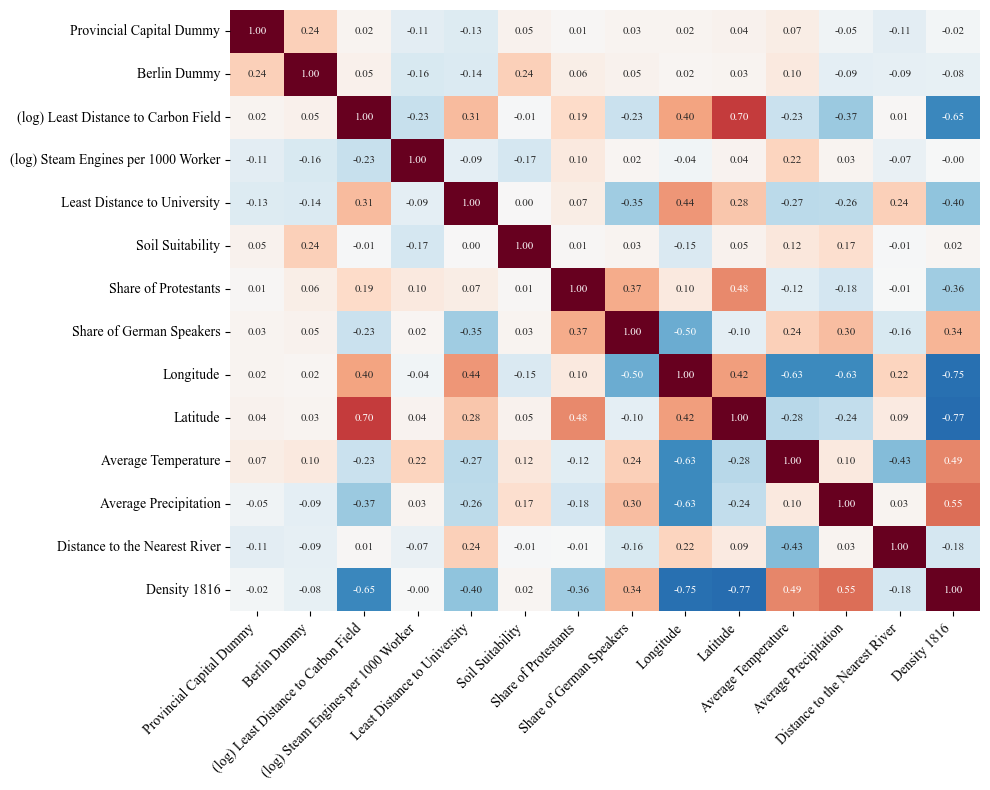

In [146]:
list_cont = [
    "(log) Least Distance to Carbon Field",
    "(log) Steam Engines per 1000 Worker",
    "Least Distance to University",
    "Soil Suitability",
    "Share of Protestants",
    "Share of German Speakers",
    "Longitude",
    "Latitude",
    "Average Temperature",
    "Average Precipitation",
    "Distance to the Nearest River",
    "Density 1816"
]

list_dummy = [
    "Provincial Capital Dummy",
    "Berlin Dummy"
]

create_heatmap(multicoll, list_cont, list_dummy)


## VIF

In [147]:
multicoll.columns

Index(['(log) Least Distance to Carbon Field', 's_industry',
       'Share of Protestants', 'Share of German Speakers', 'Longitude',
       'Latitude', 'Soil Suitability', 'Average Temperature',
       'Average Precipitation', 'Distance to the Nearest River', 'uni_dummy',
       'Least Distance to University', 'Provincial Capital Dummy',
       'Berlin Dummy', 'Density 1816', '(log) Steam Engines per 1000 Worker',
       'per_low', 'per_medium', 'per_unskilled', 'per_high', 'd_Hauptberuf',
       'horsepower', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
       'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'randomness',
       'Constant'],
      dtype='object')

In [148]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

var_list = [
    "(log) Least Distance to Carbon Field",
    "(log) Steam Engines per 1000 Worker",
    "Least Distance to University",
    "Soil Suitability",
    "Share of Protestants",
    "Share of German Speakers",
    "Longitude",
    "Latitude",
    "Average Temperature",
    "Average Precipitation",
    "Distance to the Nearest River",
    "Density 1816",
    "Provincial Capital Dummy",
    "Berlin Dummy",
    "Constant"
]

X = multicoll[var_list]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,Variable,VIF
0,(log) Least Distance to Carbon Field,2.849101
1,(log) Steam Engines per 1000 Worker,1.492349
2,Least Distance to University,1.473797
3,Soil Suitability,1.211486
4,Share of Protestants,2.031141
5,Share of German Speakers,1.917486
6,Longitude,5.661600
7,Latitude,4.586926
8,Average Temperature,3.282265
9,Average Precipitation,2.995058


# EDA

In [149]:
def change(old_X_log, new_X_log, old_y_log, coef):
    
    old_X = np.exp(old_X_log)
    new_X = np.exp(new_X_log)
    old_y = np.exp(old_y_log)
    
    percent_change_X = (new_X - old_X) / old_X * 100
    
    percent_change_y = percent_change_X * coef
    
    new_y = old_y*(1+(percent_change_y/100))
    
    return print(f"change in y: {percent_change_y:2f} %. new y:{new_y:2f}. old y:{old_y:2f}")

change(1, 1.1, 10, 1)

change in y: 10.517092 %. new y:24343.009424. old y:22026.465795


In [150]:
median_un = merged_df["per_unskilled"].median()
median_county = merged_df[merged_df["per_unskilled"] == median_un]
median_un

-0.6369777124688629

In [151]:
median_county["d_Hauptberuf"]

326    24751.0
Name: d_Hauptberuf, dtype: float64

In [152]:
Lauenburg_steam = median_county["steamengines_number"]
print(Lauenburg_steam)

326    2.488228
Name: steamengines_number, dtype: float64


In [153]:
median_un = median_county["per_unskilled"]
median_un

326   -0.636978
Name: per_unskilled, dtype: float64

In [154]:
quantile_steam = merged_df["steamengines_number"].quantile(0.75)
Lauenburg_steam = median_county["steamengines_number"]
#median_un = median_county["per_unskilled"]
median_steam = merged_df["steamengines_number"].median()
mean_steam = merged_df["steamengines_number"].mean()
change(2.488228, quantile_steam, -0.636978, -0.198)

change in y: -6.195839 %. new y:0.496119. old y:0.528888


In [155]:
quantile_steam = merged_df["steamengines_number"].quantile(0.75)
Lauenburg_steam = median_county["steamengines_number"]
median_steam = merged_df["steamengines_number"].median()
mean_steam = merged_df["steamengines_number"].mean()

quantile_steam = np.exp(quantile_steam)
median_steam = np.exp(median_steam)
mean_steam = np.exp(mean_steam)
print(quantile_steam)
print(median_steam)
print(mean_steam)
print(f"Lauenburg steams: {np.exp(median_county['steamengines_number'])}")
print(f"Lauenburg per un: {np.exp(median_county['per_unskilled'])}")
print(f"Lauenburg per un: {median_county['unskilled']}")

15.80746916345479
11.25495863956456
10.948161341606077
Lauenburg steams: 326    12.039918
Name: steamengines_number, dtype: float64
Lauenburg per un: 326    0.528888
Name: per_unskilled, dtype: float64
Lauenburg per un: 326    13090.518372
Name: unskilled, dtype: float64


In [156]:
24751*0.496119

12279.441369